In [12]:
#%whos
%reset
# Talk_ID == 2113 (Ghana)

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


Invalid alias: The name clear can't be aliased because it is another magic command.
Invalid alias: The name more can't be aliased because it is another magic command.
Invalid alias: The name less can't be aliased because it is another magic command.
Invalid alias: The name man can't be aliased because it is another magic command.


In [13]:
import numpy as np
import pandas as pd
import math
import pickle
import string
import unicodedata
from collections import Counter

import re
import contractions
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

from textblob import TextBlob
import streamlit as st
import time
import gensim
import matplotlib.pyplot as plt
from selenium import webdriver

# Functions

In [6]:
# Apply a first round of text cleaning techniques (from AZ)
def clean_text_round1(text):
    '''Make text lowercase, remove text in parentheses, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    #inserted a contractions expander
    text = contractions.fix(text)
    text = re.sub('\[.*?\]', '', text)
    # further text standardizers
    text = re.sub('@\S+', '', text)
    text = re.sub("@", "at", text)     

    text = re.sub('(Chris Anderson:)', '', text)
    text = re.sub('(\(applause\))', '', text)
    text = re.sub('(\(laughter\))', '', text)
    # remove extra whitespace
    text = re.sub(' +', ' ', text)
    # remove extra newlines
    text = re.sub(r'[\r|\n|\r\n]+', ' ',text)

    #Jay's attempts to remove everything w/ parentheses
#    text = re.sub('\(.*?\)', '', text)
#    text = re.sub('\([^)]*\)', '', text)
#    text = re.sub(r'\([^()]*\)', '', text)

    # to remove accented characters
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', str(text))
    text = re.sub('\w*\d\w*', '', text)
    return text

In [7]:
# Apply a second round of cleaning
def clean_text_round2(text):
    '''Get rid of some additional punctuation and non-sensical text that was missed the first time around.'''
    text = re.sub('[‘’“”—…]', '', text)
    text = re.sub('\n', '', text)
    return text

In [125]:
def lemmadata(doc):
    wordnet_lemmatizer = WordNetLemmatizer()
    english = set(nltk.corpus.words.words())
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    raw_tokens = nltk.regexp_tokenize(doc, pattern)
    tokens = [i.lower() for i in raw_tokens]
    stop_words = set(stopwords.words('english'))
    listed = [w for w in tokens if not w in stop_words]
    lemmatized = [wordnet_lemmatizer.lemmatize(word, pos="v") for word in listed]
    words = list(filter(lambda w: w in english, lemmatized))
    return " ".join(words)

# from within classifier function (filters out 'lb'- what is that?)
# def lemmadata(doc):
#     pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
#     raw_tokens = nltk.regexp_tokenize(doc, pattern)
#     tokens = [i.lower() for i in raw_tokens]
#     stop_words = set(stopwords.words('english'))
#     listed = [w for w in tokens if not w in stop_words]
#     lemmatized = [wordnet_lemmatizer.lemmatize(word, pos="v") for word in listed]
#     lemmatized = list(filter(lambda w: w != 'lb', lemmatized))
#     words = list(filter(lambda w: w in english, lemmatized))
#     return " ".join(words)

In [104]:
# Split each routine into 10 parts
def split_text(text, n=10):
    '''Takes in a string of text and splits into n equal parts, with a default of 10 equal parts.'''

    # Calculate length of text, the size of each chunk of text and the starting points of each chunk of text
    length = len(text)
    size = math.floor(length / n)
    start = np.arange(0, length, size)
    
    # Pull out equally sized pieces of text and put it into a list
    split_list = []
    for piece in range(n):
        split_list.append(text[start[piece]:start[piece]+size])
    return split_list

# Pre-process DataFrame

In [9]:
df1 = pd.read_csv("data/Release_v0/TEDonly_speakers_final.csv")

In [10]:
df2 = pd.read_csv("data/Release_v0/TEDplus_speakers_final.csv")

In [11]:
# confirm the two files have identical columns
for c in range(len(df1.columns)):
    if df1.columns[c] != df2.columns[c]:
        print(c)

In [12]:
print(len(df1), len(df2), len(df1)+len(df2))
print(df1.index, df2.index)

992 755 1747
RangeIndex(start=0, stop=992, step=1) RangeIndex(start=0, stop=755, step=1)


#### Concatenate the two main files

In [13]:
# concatenate the two main datasets
df = pd.concat([df1,df2])

In [14]:
print(df.shape)

(1747, 27)


In [15]:
#df.index
df.columns

Index(['Unnamed: 0', 'Talk_ID', 'public_url', 'headline', 'description',
       'event', 'duration', 'published', 'tags', 'views', 'text', 'speaker_1',
       'speaker1_occupation', 'speaker1_introduction', 'speaker1_profile',
       'speaker_2', 'speaker2_occupation', 'speaker2_introduction',
       'speaker2_profile', 'speaker_3', 'speaker3_occupation',
       'speaker3_introduction', 'speaker3_profile', 'speaker_4',
       'speaker4_occupation', 'speaker4_introduction', 'speaker4_profile'],
      dtype='object')

#### Remove duplicates

In [16]:
# check for duplicate Talk_ID's
duplicateRowsDF = df[df.duplicated(['Talk_ID'], keep=False)]
duplicateRowsDF

,Unnamed: 0,Talk_ID,public_url,headline,description,event,duration,published,tags,views,...,speaker2_introduction,speaker2_profile,speaker_3,speaker3_occupation,speaker3_introduction,speaker3_profile,speaker_4,speaker4_occupation,speaker4_introduction,speaker4_profile


In [17]:
#no duplicates found, but adding as part of standard pre-processing
df.drop_duplicates(subset ="Talk_ID", inplace = True)

In [18]:
# before/after dropping any duplicates
df.describe()

,Unnamed: 0,Talk_ID,views
count,1747.000000,1747.000000,1.747000e+03
mean,446.119634,1688.440183,1.952119e+06
std,266.567316,1731.956492,2.904375e+06
min,0.000000,1.000000,1.364570e+05
25%,219.500000,618.500000,8.692325e+05
50%,438.000000,1471.000000,1.238192e+06
75%,657.500000,2247.500000,1.923231e+06
max,996.000000,13062.000000,5.161409e+07


#### drop extraneous column

In [25]:
# drop columns with old csvs' row numbers
df.drop(['Unnamed: 0'], axis=1, inplace=True)

KeyError: "['Unnamed: 0'] not found in axis"

In [20]:
pd.reset_option('max_colwidth')
df.tail(20)

,Talk_ID,public_url,headline,description,event,duration,published,tags,views,text,...,speaker2_introduction,speaker2_profile,speaker_3,speaker3_occupation,speaker3_introduction,speaker3_profile,speaker_4,speaker4_occupation,speaker4_introduction,speaker4_profile
735,10681,https://www.ted.com/talks/tiffany_kagure_mugo_...,"How to have a healthier, positive relationship...",From our fear of women's bodies to our sheepis...,TEDWomen 2017,0:11:37,2/22/18,"human body,sex,humanity,society,Africa,gender ...",1038051,[This talk contains mature content Viewer di...,...,Siphumeze Khundayi is founder and artistic dir...,Why you should listen\nSiphumeze Khundayi has ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
736,10362,https://www.ted.com/talks/wendy_suzuki_the_bra...,The brain-changing benefits of exercise,What's the most transformative thing that you ...,TEDWomen 2017,0:13:02,2/28/18,"memory,exercise,neuroscience,human body,brain,...",3038783,What if I told you there was something that ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
737,10835,https://www.ted.com/talks/shameem_akhtar_to_le...,To learn is to be free,Shameem Akhtar posed as a boy during her early...,TEDWomen 2017,0:12:35,3/1/18,"gender,inequality,society,children,education,g...",982023,"A room full of boys. A girl child, hardly ni...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
738,10727,https://www.ted.com/talks/felice_belle_and_jen...,How we became sisters,Poets Felice Belle and Jennifer Murphy perform...,TEDWomen 2017,0:12:45,3/2/18,"spoken word,poetry,humanity,friendship,play,pe...",739439,Chris Waddell: Felice Bell and Jennifer Murp...,...,"Jennifer Murphy is an award-winning writer, pe...",Why you should listen\nJennifer Murphy is an a...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
739,11087,https://www.ted.com/talks/minda_dentler_what_i...,What I learned when I conquered the world's to...,"A 2.4-mile swim, a 112-mile bicycle ride and t...",TEDWomen 2017,0:13:15,3/5/18,"sports,disease,disability,goal-setting,motivat...",939881,"It was October 13, 2012, a day that I will n...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
740,11720,https://www.ted.com/talks/marc_bamuthi_joseph_...,What soccer can teach us about freedom,"""Soccer is the only thing on this planet that ...",TEDGlobal 2017,0:05:41,3/5/18,"sports,play,society,community,education,dance,...",778443,The two places where I feel most free aren't...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
741,11199,https://www.ted.com/talks/naomi_klein_how_shoc...,How shocking events can spark positive change,Things are pretty shocking out there right now...,TEDGlobal>NYC,0:15:35,3/7/18,"big problems,government,politics,climate chang...",855855,There's a question I've been puzzling over a...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
742,11685,https://www.ted.com/talks/musimbi_kanyoro_to_s...,"To solve the world's biggest problems, invest ...","As CEO of the Global Fund for Women, Musimbi K...",TEDWomen 2017,0:14:29,3/8/18,"investment,gender,women in business,community,...",953918,My mother was a philanthropist. And now I kn...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
743,11871,https://www.ted.com/talks/sophie_andrews_the_b...,The best way to help is often just to listen,A 24-hour helpline in the UK known as Samarita...,TEDMED 2017,0:14:23,3/9/18,"depression,friendship,TEDMED,society,aging,men...",1270738,"After cutting her arm with a broken glass, s...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
744,11089,https://www.ted.com/talks/ike_ude_the_radical_...,"The radical beauty of Africa, in portraits",Throughout his colorful career and bodies of w...,TEDGlobal 2017,0:13:23,3/12/18,"photography,Africa,social change,beauty,identi...",191469,"In 1996, I was commissioned by the Guggenhei...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
# double-check that all Talk ID's are unique
len(df['Talk_ID'].unique())

1747

In [22]:
# since Talk ID's are unique, set as index
df.set_index('Talk_ID', inplace=True)

In [23]:
pd.reset_option('max_colwidth')
df.tail(16)

,public_url,headline,description,event,duration,published,tags,views,text,speaker_1,...,speaker2_introduction,speaker2_profile,speaker_3,speaker3_occupation,speaker3_introduction,speaker3_profile,speaker_4,speaker4_occupation,speaker4_introduction,speaker4_profile
Talk_ID,,,,,,,,,,,,,,,,,,,,,
11087,https://www.ted.com/talks/minda_dentler_what_i...,What I learned when I conquered the world's to...,"A 2.4-mile swim, a 112-mile bicycle ride and t...",TEDWomen 2017,0:13:15,3/5/18,"sports,disease,disability,goal-setting,motivat...",939881,"It was October 13, 2012, a day that I will n...",Minda Dentler,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11720,https://www.ted.com/talks/marc_bamuthi_joseph_...,What soccer can teach us about freedom,"""Soccer is the only thing on this planet that ...",TEDGlobal 2017,0:05:41,3/5/18,"sports,play,society,community,education,dance,...",778443,The two places where I feel most free aren't...,Marc Bamuthi Joseph,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11199,https://www.ted.com/talks/naomi_klein_how_shoc...,How shocking events can spark positive change,Things are pretty shocking out there right now...,TEDGlobal>NYC,0:15:35,3/7/18,"big problems,government,politics,climate chang...",855855,There's a question I've been puzzling over a...,Naomi Klein,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11685,https://www.ted.com/talks/musimbi_kanyoro_to_s...,"To solve the world's biggest problems, invest ...","As CEO of the Global Fund for Women, Musimbi K...",TEDWomen 2017,0:14:29,3/8/18,"investment,gender,women in business,community,...",953918,My mother was a philanthropist. And now I kn...,Musimbi Kanyoro,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11871,https://www.ted.com/talks/sophie_andrews_the_b...,The best way to help is often just to listen,A 24-hour helpline in the UK known as Samarita...,TEDMED 2017,0:14:23,3/9/18,"depression,friendship,TEDMED,society,aging,men...",1270738,"After cutting her arm with a broken glass, s...",Sophie Andrews,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11089,https://www.ted.com/talks/ike_ude_the_radical_...,"The radical beauty of Africa, in portraits",Throughout his colorful career and bodies of w...,TEDGlobal 2017,0:13:23,3/12/18,"photography,Africa,social change,beauty,identi...",191469,"In 1996, I was commissioned by the Guggenhei...",Iké Udé,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11486,https://www.ted.com/talks/deanna_van_buren_wha...,What a world without prisons could look like,Deanna Van Buren designs restorative justice c...,TEDWomen 2017,0:15:19,3/13/18,"justice system,prison,society,United States,so...",880973,"A lot of people call me a ""justice architect...",Deanna Van Buren,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10274,https://www.ted.com/talks/isabel_wilkerson_the...,The Great Migration and the power of a single ...,"Sometimes, a single decision can change the co...",TEDWomen 2017,0:17:55,3/15/18,"Slavery,race,inequality,history,society,United...",833416,Imagine with me this scene. It's a scene tha...,Isabel Wilkerson,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12354,https://www.ted.com/talks/sally_kohn_what_we_c...,What we can do about the culture of hate,"We're all against hate, right? We agree it's a...",TEDWomen 2017,0:17:46,3/16/18,"compassion,society,community,relationships,cul...",1039559,So people tell me I'm a nice person ... to t...,Sally Kohn,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
# double-check that all Talk ID's are (still) unique
len(df.index.unique())

1747

# Pre-process Text

In [26]:
# create new column with character-length of each speech
df['speech_length'] = df['text'].apply(len)
# create new column to flag whether speech is over or under 1M views
df['reached_threshold'] = np.where(df['views']>=1250000, 1, 0)
# create new column to flag whether tags column contains (any of my) preferred list of tags
# social change, society, global issues, humanity, community, future, health
df['prefers'] = np.where(df['tags'].str.contains('global')|df['tags'].str.contains('soci')
                         |df['tags'].str.contains('nity')|df['tags'].str.contains('activism')
                         |df['tags'].str.contains('future')|df['tags'].str.contains('health')
                         ,1, 0)
# concatenate text from several columns to include it in main transcript column ('text')
cols = ['headline', 'tags', 'description', 'text']
df['text'] = df[cols].apply(lambda x: ' '.join(x), axis = 1)

In [27]:
# check the difference
print(df.shape, df.columns)

(1747, 28) Index(['public_url', 'headline', 'description', 'event', 'duration',
       'published', 'tags', 'views', 'text', 'speaker_1',
       'speaker1_occupation', 'speaker1_introduction', 'speaker1_profile',
       'speaker_2', 'speaker2_occupation', 'speaker2_introduction',
       'speaker2_profile', 'speaker_3', 'speaker3_occupation',
       'speaker3_introduction', 'speaker3_profile', 'speaker_4',
       'speaker4_occupation', 'speaker4_introduction', 'speaker4_profile',
       'speech_length', 'reached_threshold', 'prefers'],
      dtype='object')


In [28]:
df.prefers.value_counts()

0    876
1    871
Name: prefers, dtype: int64

In [29]:
# drop any rows in which 'tags' column contains these words
to_drop = ['performance', 'music', 'magic']
nomusic_df = df[~df['tags'].str.contains('|'.join(to_drop))]

In [30]:
# check the difference
print(nomusic_df.shape, nomusic_df.columns)

(1592, 28) Index(['public_url', 'headline', 'description', 'event', 'duration',
       'published', 'tags', 'views', 'text', 'speaker_1',
       'speaker1_occupation', 'speaker1_introduction', 'speaker1_profile',
       'speaker_2', 'speaker2_occupation', 'speaker2_introduction',
       'speaker2_profile', 'speaker_3', 'speaker3_occupation',
       'speaker3_introduction', 'speaker3_profile', 'speaker_4',
       'speaker4_occupation', 'speaker4_introduction', 'speaker4_profile',
       'speech_length', 'reached_threshold', 'prefers'],
      dtype='object')


In [31]:
# check nomusic_df's index
nomusic_df.index

Int64Index([    1,    53,    66,    92,    96,    49,    71,    94,    54,
               55,
            ...
            11089, 11486, 10274, 12354, 11997, 11337, 12302, 12060, 13062,
            12202],
           dtype='int64', name='Talk_ID', length=1592)

In [50]:
# shouldn't work if Talk_ID is only the index and not also its own column
# nomusic_df.sort_values(by=['speech_length']).Talk_ID

In [32]:
#pd.reset_option('max_colwidth')
pd.set_option('max_colwidth',2000)
nomusic_df.sort_values(by=['speech_length']).text

Talk_ID
1464                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [33]:
# Missed one: Delete row with Talk_ID of 1464 
nomusic_df = nomusic_df.drop(1464)

In [35]:
print(nomusic_df.index, nomusic_df.shape, nomusic_df.columns)

Int64Index([    1,    53,    66,    92,    96,    49,    71,    94,    54,
               55,
            ...
            11089, 11486, 10274, 12354, 11997, 11337, 12302, 12060, 13062,
            12202],
           dtype='int64', name='Talk_ID', length=1591) (1591, 28) Index(['public_url', 'headline', 'description', 'event', 'duration',
       'published', 'tags', 'views', 'text', 'speaker_1',
       'speaker1_occupation', 'speaker1_introduction', 'speaker1_profile',
       'speaker_2', 'speaker2_occupation', 'speaker2_introduction',
       'speaker2_profile', 'speaker_3', 'speaker3_occupation',
       'speaker3_introduction', 'speaker3_profile', 'speaker_4',
       'speaker4_occupation', 'speaker4_introduction', 'speaker4_profile',
       'speech_length', 'reached_threshold', 'prefers'],
      dtype='object')


In [36]:
nomusic_df.prefers.value_counts()

1    831
0    760
Name: prefers, dtype: int64

Text(0, 0.5, '# of Speeches')

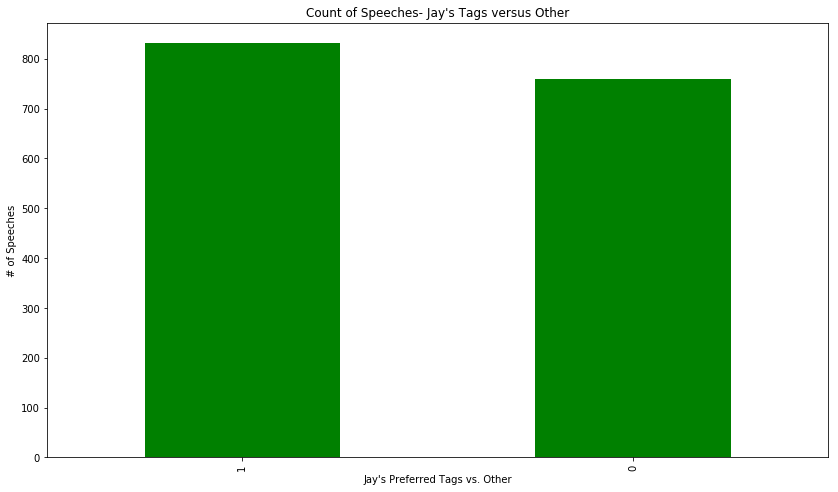

In [37]:
ax = nomusic_df['prefers'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Count of Speeches- Jay's Tags versus Other", color='green')
ax.set_xlabel("Jay's Preferred Tags vs. Other")
ax.set_ylabel("# of Speeches")

Text(0, 0.5, 'Total Views (Millions)')

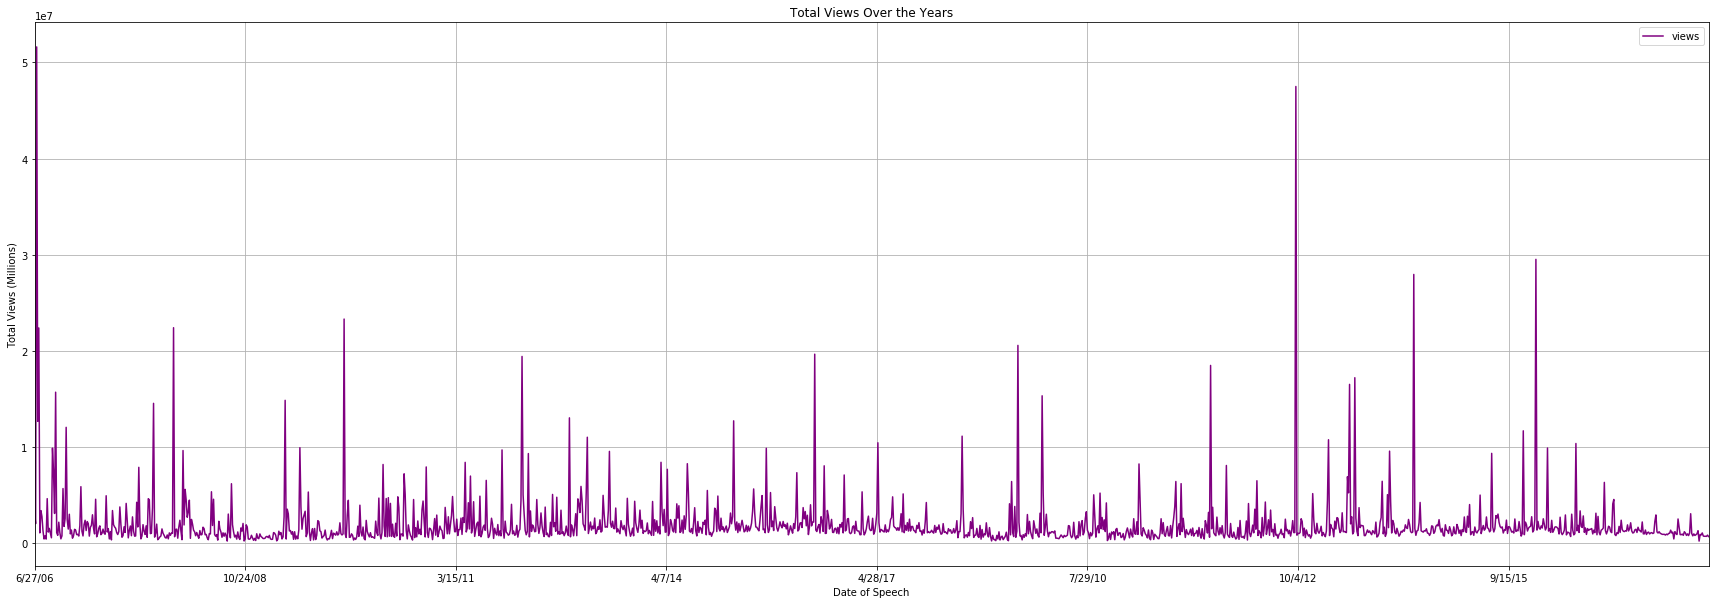

In [38]:
plt.rcParams['figure.figsize'] = [30, 10]

ax = nomusic_df.plot(x ='published', y='views', kind = 'line', color = 'purple', grid=True, title='Total Views Over the Years')
# Set the x-axis label
ax.set_xlabel("Date of Speech")

# Set the y-axis label
ax.set_ylabel("Total Views (Millions)")

In [39]:
nomusic_df.groupby("reached_threshold")["reached_threshold"].count()

reached_threshold
0    814
1    777
Name: reached_threshold, dtype: int64

In [40]:
df.tags.head(20)

Talk_ID
1              alternative energy,cars,global issues,climate change,environment,science,culture,sustainability,technology
7                         simplicity,entertainment,interface design,software,media,computers,technology,music,performance
53                               MacArthur grant,cities,green,activism,politics,pollution,environment,inequality,business
66                                                         children,teaching,creativity,parenting,culture,dance,education
92               demo,Asia,global issues,visualizations,global development,statistics,math,health,economics,Google,Africa
96                                   entertainment,goal-setting,potential,psychology,motivation,emotions,culture,business
49                                                                      library,architecture,design,culture,collaboration
86                                        atheism,Christianity,religion,God,comedy,humor,storytelling,culture,performance
71              

In [41]:
df.views.describe()

count    1.747000e+03
mean     1.952119e+06
std      2.904375e+06
min      1.364570e+05
25%      8.692325e+05
50%      1.238192e+06
75%      1.923231e+06
max      5.161409e+07
Name: views, dtype: float64

### Explode the list of tags

In [77]:
# reset index from Talk_ID to generic array
# df.reset_index(inplace=True)
pd.reset_option('max_colwidth')
pre_expl_df = nomusic_df.reset_index(drop=True)
pre_expl_df.tail(16)

,Talk_ID,public_url,headline,description,event,duration,published,tags,views,text,...,speaker3_occupation,speaker3_introduction,speaker3_profile,speaker_4,speaker4_occupation,speaker4_introduction,speaker4_profile,speech_length,reached_threshold,prefers
1575,10727,https://www.ted.com/talks/felice_belle_and_jen...,How we became sisters,Poets Felice Belle and Jennifer Murphy perform...,TEDWomen 2017,0:12:45,3/2/18,"spoken word,poetry,humanity,friendship,play,pe...",739439,"How we became sisters spoken word,poetry,human...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9612,0,1
1576,11087,https://www.ted.com/talks/minda_dentler_what_i...,What I learned when I conquered the world's to...,"A 2.4-mile swim, a 112-mile bicycle ride and t...",TEDWomen 2017,0:13:15,3/5/18,"sports,disease,disability,goal-setting,motivat...",939881,What I learned when I conquered the world's to...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10330,0,0
1577,11720,https://www.ted.com/talks/marc_bamuthi_joseph_...,What soccer can teach us about freedom,"""Soccer is the only thing on this planet that ...",TEDGlobal 2017,0:05:41,3/5/18,"sports,play,society,community,education,dance,...",778443,"What soccer can teach us about freedom sports,...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4075,0,1
1578,11199,https://www.ted.com/talks/naomi_klein_how_shoc...,How shocking events can spark positive change,Things are pretty shocking out there right now...,TEDGlobal>NYC,0:15:35,3/7/18,"big problems,government,politics,climate chang...",855855,How shocking events can spark positive change ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12397,0,1
1579,11685,https://www.ted.com/talks/musimbi_kanyoro_to_s...,"To solve the world's biggest problems, invest ...","As CEO of the Global Fund for Women, Musimbi K...",TEDWomen 2017,0:14:29,3/8/18,"investment,gender,women in business,community,...",953918,"To solve the world's biggest problems, invest ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9313,0,1
1580,11871,https://www.ted.com/talks/sophie_andrews_the_b...,The best way to help is often just to listen,A 24-hour helpline in the UK known as Samarita...,TEDMED 2017,0:14:23,3/9/18,"depression,friendship,TEDMED,society,aging,men...",1270738,The best way to help is often just to listen d...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13018,1,1
1581,11089,https://www.ted.com/talks/ike_ude_the_radical_...,"The radical beauty of Africa, in portraits",Throughout his colorful career and bodies of w...,TEDGlobal 2017,0:13:23,3/12/18,"photography,Africa,social change,beauty,identi...",191469,"The radical beauty of Africa, in portraits pho...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7282,0,1
1582,11486,https://www.ted.com/talks/deanna_van_buren_wha...,What a world without prisons could look like,Deanna Van Buren designs restorative justice c...,TEDWomen 2017,0:15:19,3/13/18,"justice system,prison,society,United States,so...",880973,What a world without prisons could look like j...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12551,0,1
1583,10274,https://www.ted.com/talks/isabel_wilkerson_the...,The Great Migration and the power of a single ...,"Sometimes, a single decision can change the co...",TEDWomen 2017,0:17:55,3/15/18,"Slavery,race,inequality,history,society,United...",833416,The Great Migration and the power of a single ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12694,0,1
1584,12354,https://www.ted.com/talks/sally_kohn_what_we_c...,What we can do about the culture of hate,"We're all against hate, right? We agree it's a...",TEDWomen 2017,0:17:46,3/16/18,"compassion,society,community,relationships,cul...",1039559,What we can do about the culture of hate compa...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12966,0,1


In [78]:
# (1) Create a new dataframe from the series with Talk_ID as the index
exploding_df = pd.DataFrame(pre_expl_df.tags.str.split(',').tolist(), index=pre_expl_df.Talk_ID).stack()

In [93]:
exploding_df.index

MultiIndex(levels=[[1, 53, 66, 92, 96, 49, 71, 94, 54, 55, 58, 41, 65, 27, 2, 25, 21, 16, 20, 29, 97, 12, 89, 4, 56, 57, 59, 22, 19, 38, 70, 10, 62, 69, 34, 68, 48, 90, 83, 84, 85, 5, 9, 11, 28, 32, 80, 50, 76, 77, 78, 18, 31, 35, 40, 102, 104, 105, 113, 112, 72, 118, 121, 122, 123, 125, 126, 128, 129, 127, 131, 8, 33, 139, 140, 141, 116, 142, 144, 143, 146, 148, 147, 149, 170, 82, 161, 162, 163, 171, 172, 167, 176, 178, 165, 182, 190, 184, 189, 191, 187, 183, 195, 197, 194, 51, 200, 201, 202, 204, 203, 145, 205, 206, 207, 13, 208, 211, 212, 213, 215, 214, 216, 221, 219, 222, 223, 225, 224, 228, 227, 230, 229, 231, 233, 234, 232, 236, 237, 235, 239, 242, 243, 245, 251, 250, 253, 258, 259, 261, 248, 264, 266, 267, 270, 269, 271, 273, 276, 278, 279, 252, 280, 285, 292, 300, 282, 306, 307, 308, 312, 294, 315, 316, 318, 321, 326, 324, 331, 333, 344, 343, 347, 345, 341, 353, 351, 272, 349, 354, 355, 356, 358, 361, 363, 362, 371, 377, 374, 379, 381, 365, 383, 385, 388, 390, 391, 393, 394, 39

In [79]:
exploding_df.head(20)

Talk_ID   
1        0    alternative energy
         1                  cars
         2         global issues
         3        climate change
         4           environment
         5               science
         6               culture
         7        sustainability
         8            technology
53       0       MacArthur grant
         1                cities
         2                 green
         3              activism
         4              politics
         5             pollution
         6           environment
         7            inequality
         8              business
66       0              children
         1              teaching
dtype: object

In [90]:
j_exploded_df = exploding_df.reset_index(['Talk_ID'])
j_exploded_df.tail(12)
# jsexploded_df.index

,Talk_ID,0
5,13062,plants
6,13062,science
7,13062,communication
0,12202,religion
1,12202,faith
2,12202,society
3,12202,Africa
4,12202,community
5,12202,education
6,12202,health care


In [61]:
# (2) Now discard secondary index. To do this, make Talk_ID
# as a column (it can't be an index since the values will be duplicate)
exploded_df = exploding_df.reset_index([0, 'Talk_ID'])

# (3) The final step is to set the column names as we want them
exploded_df.columns = ['Talk_ID', 'tag']

In [62]:
exploded_df.head(20)

,Talk_ID,tag
0,1,alternative energy
1,1,cars
2,1,global issues
3,1,climate change
4,1,environment
5,1,science
6,1,culture
7,1,sustainability
8,1,technology
9,53,MacArthur grant


In [73]:
# merge original dataframe with this new one
df = pd.merge(df, exploded_df, on='Talk_ID')

In [74]:
# Save & Store File (Pickle)

filename = "exploded2"
outfile = open(filename, 'wb')
pickle.dump(df, outfile)
outfile.close()

In [5]:
# Retrieve File (Un-pickle)
filename = 'exploded2'
infile = open(filename,'rb')
new_file = pickle.load(infile)
infile.close()

In [6]:
df = new_file

In [7]:
### ALL TAGS ###
# df['tag'].value_counts(ascending=True)
df['tag'].value_counts()

technology         510
science            402
global issues      333
culture            319
design             287
business           224
social change      176
society            171
health             153
innovation         144
future             141
art                135
biology            131
humanity           130
creativity         129
TED Fellows        127
entertainment      125
communication      125
medicine           118
activism           118
economics          113
collaboration      112
brain              109
Africa             107
invention          104
community          103
environment        103
health care         94
education           93
politics            88
                  ... 
evil                 2
hearing              2
monkeys              2
Nobel Prize          2
Brand                2
population           2
state-building       2
epidemiology         2
urban                2
science fiction      2
novel                2
funny                2
homelessnes

In [ ]:
print(len(df.tag.unique()))
df.tag.unique()

In [ ]:
# df.groupby('tag').filter(lambda x: len(x) < 88).sort_values(by=['speech_length'])
# df.groupby('tag').filter(lambda x: len(x) < 88)

In [ ]:
# filter to only tags that are used at least 80 times
# df_filtered = df.groupby('tag').filter(lambda x: len(x) >= 80)

In [153]:
nomusic_df.shape

(1591, 28)

In [79]:
# compress df to remove duplicate rows (created from exploding 'tags'), leaving only unique Talk_ID
de_exploded_df = df.drop_duplicates('Talk_ID')

In [80]:
print(de_exploded_df.shape, de_exploded_df.index,'\n', de_exploded_df.columns)

(1591, 30) Int64Index([    0,     9,    18,    25,    36,    44,    49,    57,    65,
               75,
            ...
            12031, 12039, 12044, 12052, 12058, 12066, 12073, 12083, 12092,
            12100],
           dtype='int64', length=1591) 
 Index(['Talk_ID', 'public_url', 'headline', 'description', 'event', 'duration',
       'published', 'tags', 'views', 'text', 'speaker_1',
       'speaker1_occupation', 'speaker1_introduction', 'speaker1_profile',
       'speaker_2', 'speaker2_occupation', 'speaker2_introduction',
       'speaker2_profile', 'speaker_3', 'speaker3_occupation',
       'speaker3_introduction', 'speaker3_profile', 'speaker_4',
       'speaker4_occupation', 'speaker4_introduction', 'speaker4_profile',
       'speech_length', 'reached_threshold', 'prefers', 'tag'],
      dtype='object')


In [158]:
# potential to-do: truncate more non-lengthy speeches (find cut-off)
pd.set_option('max_colwidth',2000)
nomusic_df.sort_values(by=['speech_length']).text
# nomusic_df.sort_values(by=['speech_length']).speech_length
# de_exploded_df.sample(20)

Talk_ID
1622                                                                Forget multitasking, try monotasking humor,design,product design,culture,technology People don't just cook anymore -- they're cooking, texting, talking on the phone, watching YouTube and uploading photos of the awesome meal they just made. Designer Paolo Cardini questions the efficiency of our multitasking world and makes the case for -- gasp -- "monotasking."   I'm a designer and an educator. I'm a multitasking person, and I push my students to fly through a very creative, multitasking design process. But how efficient is, really, this multitasking?    Let's consider for a while the option of monotasking. A couple of examples. Look at that. This is my multitasking activity result. (Laughter) So trying to cook, answering the phone, writing SMS, and maybe uploading some pictures about this awesome barbecue.    So someone tells us the story about supertaskers, so this two percent of people who are able to control

In [160]:
nomusic_df.describe()

,views,speech_length,reached_threshold,prefers
count,1.591000e+03,1591.000000,1591.000000,1591.000000
mean,1.940542e+06,11652.783784,0.488372,0.522313
std,2.936802e+06,5271.789839,0.500022,0.499659
min,1.914690e+05,1576.000000,0.000000,0.000000
25%,8.792555e+05,7567.000000,0.000000,0.000000
50%,1.239901e+06,11834.000000,0.000000,1.000000
75%,1.910758e+06,15344.500000,1.000000,1.000000
max,5.161409e+07,35091.000000,1.000000,1.000000


### Additional Pre-processing Approaches

In [42]:
pd.set_option('max_colwidth',2000)
# pd.reset_option('max_colwidth')
# df.text[df.tag == 'entertainment'].sample(20)

#df_filtered.text.sample(10)
df.text.sample(20)

Talk_ID
630     How we read each other's minds morality,brain,science,technology Sensing the motives and feelings of others is a natural talent for humans. But how do we do it? Here, Rebecca Saxe shares fascinating lab work that uncovers how the brain thinks about other peoples' thoughts -- and judges their actions.   Today I'm going to talk to you about the problem of other minds. And the problem I'm going to talk about is not the familiar one from philosophy, which is, "How can we know whether other people have minds?" That is, maybe you have a mind, and everyone else is just a really convincing robot. So that's a problem in philosophy, but for today's purposes I'm going to assume that many people in this audience have a mind, and that I don't have to worry about this.    There is a second problem that is maybe even more familiar to us as parents and teachers and spouses and novelists, which is, "Why is it so hard to know what somebody else wants or believes?" Or perhaps, more releva

In [43]:
pd.reset_option('max_colwidth')
df.sample(8)

,public_url,headline,description,event,duration,published,tags,views,text,speaker_1,...,speaker3_occupation,speaker3_introduction,speaker3_profile,speaker_4,speaker4_occupation,speaker4_introduction,speaker4_profile,speech_length,reached_threshold,prefers
Talk_ID,,,,,,,,,,,,,,,,,,,,,
2336,https://www.ted.com/talks/robin_morgan_4_power...,4 powerful poems about Parkinson's and growing...,When poet Robin Morgan found herself facing Pa...,TEDWomen 2015,0:11:57,9/25/15,"aging,health,poetry,disease,personal growth",1032653,4 powerful poems about Parkinson's and growing...,Robin Morgan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7914,0,1
94,https://www.ted.com/talks/dan_dennett_s_respon...,Let's teach religion -- all religion -- in sch...,Philosopher Dan Dennett calls for religion -- ...,TED2006,0:24:45,7/18/06,"atheism,consciousness,evolution,philosophy,rel...",2751013,Let's teach religion -- all religion -- in sch...,Dan Dennett,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20267,1,0
640,https://www.ted.com/talks/jonathan_zittrain_th...,The Web as random acts of kindness,Feeling like the world is becoming less friend...,TEDGlobal 2009,0:19:51,9/21/09,"wikipedia,web,Internet,law,culture,technology",746424,"The Web as random acts of kindness wikipedia,w...",Jonathan Zittrain,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16887,0,0
2258,https://www.ted.com/talks/martine_rothblatt_my...,"My daughter, my wife, our robot, and the quest...","The founder of Sirius XM satellite radio, Mart...",TED2015,0:21:04,5/18/15,"Gender spectrum,Transgender,biotech,love,medic...",1380884,"My daughter, my wife, our robot, and the quest...",Martine Rothblatt,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17718,1,0
1800,https://www.ted.com/talks/eleanor_longden_the_...,The voices in my head,"To all appearances, Eleanor Longden was just l...",TED2013,0:14:17,8/8/13,"health,health care,mental health",4335384,"The voices in my head health,health care,menta...",Eleanor Longden,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13898,1,1
39,https://www.ted.com/talks/aubrey_de_grey_says_...,A roadmap to end aging,Cambridge researcher Aubrey de Grey argues tha...,TEDGlobal 2005,0:22:45,10/2/06,"biotech,engineering,aging,health care,disease,...",3467757,"A roadmap to end aging biotech,engineering,agi...",Aubrey de Grey,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26039,1,1
11199,https://www.ted.com/talks/naomi_klein_how_shoc...,How shocking events can spark positive change,Things are pretty shocking out there right now...,TEDGlobal>NYC,0:15:35,3/7/18,"big problems,government,politics,climate chang...",855855,How shocking events can spark positive change ...,Naomi Klein,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12397,0,1
1131,https://www.ted.com/talks/harvey_fineberg_are_...,Are we ready for neo-evolution?,Medical ethicist Harvey Fineberg shows us thre...,TED2011,0:17:21,4/25/11,"evolution,bioethics,marine biology,philosophy,...",1036830,"Are we ready for neo-evolution? evolution,bioe...",Harvey Fineberg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13242,0,0


In [81]:
# Save & Store File (Pickle)

filename = "de_exploded"
outfile = open(filename, 'wb')
pickle.dump(de_exploded_df, outfile)
outfile.close()

In [82]:
# Retrieve File (Un-pickle)
filename = 'de_exploded'
infile = open(filename,'rb')
new_file = pickle.load(infile)
infile.close()

In [83]:
de_exploded_df = new_file

#### Apply Text Cleaning

In [44]:
# df = de_exploded_df
# to circumvent exploding portion above
df = nomusic_df

In [45]:
pd.set_option('max_colwidth',2000)
df['text'].tail()

Talk_ID
11337    What if gentrification was about healing communities instead of displacing them? architecture,society,community,urban planning,collaboration,social change,design Liz Ogbu is an architect who works on spatial justice: the idea that justice has a geography and that the equitable distribution of resources and services is a human right. In San Francisco, she's questioning the all too familiar story of gentrification: that poor people will be pushed out by development and progress. "Why is it that we treat culture erasure and economic displacement as inevitable?" she asks, calling on developers, architects and policymakers to instead "make a commitment to build people's capacity to stay in their homes, to stay in their communities, to stay where they feel whole."   I grew up in a family of social scientists, but I was the weird child who drew.    (Laughter)    From making sketches of the models in my mom's Sears catalog ... to a bedroom so full of my craft projects that it 

In [46]:
#pd.reset_option('max_colwidth')
pd.set_option('max_colwidth',2000)
df.text[df.index == 2113]

Talk_ID
2113    The leaders who ruined Africa, and the generation who can fix it TED Fellows,Africa,entrepreneur Before he hit eighteen, Fred Swaniker had lived in Ghana, Gambia, Botswana and Zimbabwe. What he learned from a childhood across Africa was that while good leaders can't make much of a difference in societies with strong institutions, in countries with weak structures, leaders could make or break a country. In a passionate talk the entrepreneur and TED Fellow looks at different generations of African leaders and imagines how to develop the leadership of the future.   I experienced my first coup d'état at the age of four. Because of the coup d'état, my family had to leave my native home of Ghana and move to the Gambia. As luck would have it, six months after we arrived, they too had a military coup. I vividly remember being woken up in the middle of the night and gathering the few belongings we could and walking for about two hours to a safe house. For a week, we slept under 

In [47]:
# calling function clean_text_round1
round1 = lambda x: clean_text_round1(x)

In [48]:
df.text = pd.DataFrame(df.text.apply(round1))

In [49]:
pd.set_option('max_colwidth',1000)
# df.text[df.Talk_ID == 2113]
df.text[df.index == 2113]

Talk_ID
2113    the leaders who ruined africa  and the generation who can fix it ted fellows africa entrepreneur before he hit eighteen  fred swaniker had lived in ghana  gambia  botswana and zimbabwe  what he learned from a childhood across africa was that while good leaders can not make much of a difference in societies with strong institutions  in countries with weak structures  leaders could make or break a country  in a passionate talk the entrepreneur and ted fellow looks at different generations of african leaders and imagines how to develop the leadership of the future  i experienced my first coup d etat at the age of four  because of the coup d etat  my family had to leave my native home of ghana and move to the gambia  as luck would have it  six months after we arrived  they too had a military coup  i vividly remember being woken up in the middle of the night and gathering the few belongings we could and walking for about two hours to a safe house  for a week  we slept under 

In [50]:
round2 = lambda x: clean_text_round2(x)

In [51]:
# Let's take a look at the updated text
df.text = pd.DataFrame(df.text.apply(round2))

In [52]:
pd.set_option('max_colwidth',2000)
# df.text[df.Talk_ID == 2113]
df.text[df.index == 2113]

Talk_ID
2113    the leaders who ruined africa  and the generation who can fix it ted fellows africa entrepreneur before he hit eighteen  fred swaniker had lived in ghana  gambia  botswana and zimbabwe  what he learned from a childhood across africa was that while good leaders can not make much of a difference in societies with strong institutions  in countries with weak structures  leaders could make or break a country  in a passionate talk the entrepreneur and ted fellow looks at different generations of african leaders and imagines how to develop the leadership of the future  i experienced my first coup d etat at the age of four  because of the coup d etat  my family had to leave my native home of ghana and move to the gambia  as luck would have it  six months after we arrived  they too had a military coup  i vividly remember being woken up in the middle of the night and gathering the few belongings we could and walking for about two hours to a safe house  for a week  we slept under 

In [53]:
data_clean = df

In [54]:
#pd.reset_option('max_colwidth')
pd.set_option('max_colwidth',2000)
# df['text'].head(4)
#data_clean.sample(8)
data_clean.text[df.index == 2113]

Talk_ID
2113    the leaders who ruined africa  and the generation who can fix it ted fellows africa entrepreneur before he hit eighteen  fred swaniker had lived in ghana  gambia  botswana and zimbabwe  what he learned from a childhood across africa was that while good leaders can not make much of a difference in societies with strong institutions  in countries with weak structures  leaders could make or break a country  in a passionate talk the entrepreneur and ted fellow looks at different generations of african leaders and imagines how to develop the leadership of the future  i experienced my first coup d etat at the age of four  because of the coup d etat  my family had to leave my native home of ghana and move to the gambia  as luck would have it  six months after we arrived  they too had a military coup  i vividly remember being woken up in the middle of the night and gathering the few belongings we could and walking for about two hours to a safe house  for a week  we slept under 

In [55]:
# within lemmadata fn: tokenize, lemmatize, and un-tokenize (re-join) text
data_clean['text'] = data_clean['text'].apply(lambda x: lemmadata(x))

In [57]:
data_clean.text[data_clean.index == 2113]

Talk_ID
2113    ruin generation fix ted entrepreneur hit eighteen live gambia zimbabwe learn childhood across good make much difference strong weak structure could make break country passionate talk entrepreneur ted fellow look different imagine develop leadership future experience first coup age four coup family leave native home move gambia luck would six arrive military coup vividly remember wake middle night gather belong could walk two safe house week sleep bed worry might fly window age eight move time different everything work great education good infrastructure even time fiber optic telephone system long reach western thing national television station remember watch neighbor south watch nelson jail offer chance come would give apartheid struggle refuse actually achieve objective free south apartheid remember feel one good leader could make big difference age family send high school zimbabwe initially amaze grow economy excellent infrastructure seem like model economic developme

#### Checkpoint

In [44]:
# Let's also pickle the cleaned data 
# (before we put it in document-term matrix format) and the CountVectorizer object
data_clean.to_pickle('data_clean.pkl')

In [65]:
data_clean = pd.read_pickle('data_clean.pkl')

In [58]:
# data_clean.describe()
print(data_clean.shape, data_clean.columns)

(1591, 28) Index(['public_url', 'headline', 'description', 'event', 'duration',
       'published', 'tags', 'views', 'text', 'speaker_1',
       'speaker1_occupation', 'speaker1_introduction', 'speaker1_profile',
       'speaker_2', 'speaker2_occupation', 'speaker2_introduction',
       'speaker2_profile', 'speaker_3', 'speaker3_occupation',
       'speaker3_introduction', 'speaker3_profile', 'speaker_4',
       'speaker4_occupation', 'speaker4_introduction', 'speaker4_profile',
       'speech_length', 'reached_threshold', 'prefers'],
      dtype='object')


In [59]:
# Create a document-term matrix using sklearn's
# CountVectorizer, and exclude common English stop words
# from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words='english')

In [75]:
data_cv = cv.fit_transform(data_clean.text)
print(len(cv.get_feature_names()), data_cv.shape)

20187 (1591, 20187)


In [73]:
print(cv.get_feature_names(), data_cv)

['aa', 'aba', 'aback', 'abacus', 'abalone', 'abandon', 'abandonment', 'abashedly', 'abate', 'abbey', 'abbreviate', 'abbreviation', 'abdicate', 'abdication', 'abdomen', 'abdominal', 'abduct', 'abduction', 'abecedarian', 'abed', 'aberrant', 'aberration', 'abet', 'abhor', 'abhorrent', 'abide', 'abigail', 'ability', 'abir', 'abject', 'ablate', 'ablation', 'ablaze', 'able', 'abnormal', 'abnormality', 'aboard', 'abolish', 'abolition', 'abolitionism', 'abominable', 'abomination', 'aboriginal', 'abort', 'abortion', 'abound', 'aboveboard', 'aboveground', 'abrasion', 'abridge', 'abroad', 'abrupt', 'abruptly', 'abscess', 'abscond', 'absence', 'absent', 'absentee', 'absenteeism', 'absinthe', 'absolute', 'absolutely', 'absolution', 'absolutism', 'absolutist', 'absolve', 'absorb', 'absorbency', 'absorbent', 'absorber', 'absorption', 'absquatulate', 'abstain', 'abstinence', 'abstract', 'abstraction', 'abstractly', 'abstruse', 'absurd', 'absurdity', 'absurdly', 'abu', 'abundance', 'abundant', 'abundan

In [76]:
# Create Document-Term Matrix
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = data_clean.index
data_dtm

,aa,aba,aback,abacus,abalone,abandon,abandonment,abashedly,abate,abbey,...,zombie,zone,zoo,zoologist,zoology,zoom,zoonotic,zoophilia,zooplankton,zygomatic
Talk_ID,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
53,0,0,0,0,0,2,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0
66,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
92,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49,0,0,0,0,0,0,0,0,0,0,...,0,3,0,0,0,0,0,0,0,0
71,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
94,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
54,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [77]:
# len(data_dtm.columns)
data_dtm.shape

(1591, 20187)

In [65]:
# Let's pickle it for later use
data_dtm.to_pickle("dtm.pkl")

In [66]:
# Let's also pickle the cleaned data (before we put it in document-term matrix format) and the CountVectorizer object
# data_clean.to_pickle('data_clean.pkl')
pickle.dump(cv, open("cv.pkl", "wb"))

##### Most Common Words

In [67]:
data = pd.read_pickle('dtm.pkl')

In [68]:
# Transpose DTM into a Term-Document Matrix (TDM)
print(len(data.columns))
data = data.transpose()
print(len(data.columns))
data.sample(20)

20187
1591


Talk_ID,1,53,66,92,96,49,71,94,54,55,...,11089,11486,10274,12354,11997,11337,12302,12060,13062,12202
brevity,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
cultural,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
persevere,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
rapport,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
lan,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
cloudiness,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
chapman,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
cane,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
concertina,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
microglia,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [78]:
# Find the top 30 words said in each speech
top_dict = {}
for c in data.columns:
    top = data[c].sort_values(ascending=False).head(30)
    top_dict[c]= list(zip(top.index, top.values))
top_dict

{1: [('say', 13),
  ('make', 9),
  ('people', 9),
  ('come', 9),
  ('carbon', 9),
  ('climate', 8),
  ('global', 7),
  ('way', 7),
  ('new', 6),
  ('use', 6),
  ('like', 6),
  ('want', 6),
  ('lot', 6),
  ('story', 6),
  ('tipper', 6),
  ('time', 6),
  ('al', 5),
  ('warm', 5),
  ('know', 5),
  ('really', 5),
  ('restaurant', 5),
  ('buy', 5),
  ('reduce', 5),
  ('truck', 4),
  ('mean', 4),
  ('brand', 4),
  ('efficiency', 4),
  ('world', 4),
  ('start', 4),
  ('night', 4)],
 53: [('south', 17),
  ('like', 16),
  ('community', 14),
  ('city', 13),
  ('people', 13),
  ('new', 11),
  ('make', 11),
  ('park', 11),
  ('come', 10),
  ('build', 10),
  ('environmental', 10),
  ('waste', 9),
  ('time', 9),
  ('green', 8),
  ('use', 8),
  ('live', 8),
  ('development', 8),
  ('plan', 8),
  ('percent', 7),
  ('project', 7),
  ('help', 7),
  ('justice', 7),
  ('common', 7),
  ('tell', 6),
  ('create', 6),
  ('sustainable', 6),
  ('line', 6),
  ('economic', 6),
  ('world', 6),
  ('little', 6)],
 6

In [79]:
# Print the top 15 words
for speech_num, top_words in top_dict.items():
    print(speech_num)
    print(', '.join([word for word, count in top_words[0:14]]))
    print('---')

1
say, make, people, come, carbon, climate, global, way, new, use, like, want, lot, story
---
53
south, like, community, city, people, new, make, park, come, build, environmental, waste, time, green
---
66
say, think, education, people, know, come, school, like, want, way, talk, creativity, really, dance
---
92
world, like, data, country, look, health, life, percent, income, come, people, south, change, think
---
96
people, know, say, need, make, tell, life, want, love, way, emotion, aye, different, shape
---
49
build, actually, sort, theater, library, space, say, book, happen, design, forth, public, want, art
---
71
say, think, life, god, make, know, believe, influence, good, want, start, come, book, money
---
94
think, design, say, god, want, make, really, book, know, natural, read, people, life, talk
---
54
design, work, community, build, world, know, want, people, develop, live, involve, say, come, start
---
55
people, film, world, know, think, day, wish, like, way, come, feel, pow

In [80]:
# Look at the most common top words --> add them to the stop word list
# Let's first pull out the top 30 words for each speech
words = []
for speech_num in data.columns:
    top = [word for (word, count) in top_dict[speech_num]]
    for t in top:
        words.append(t)  
words

['say',
 'make',
 'people',
 'come',
 'carbon',
 'climate',
 'global',
 'way',
 'new',
 'use',
 'like',
 'want',
 'lot',
 'story',
 'tipper',
 'time',
 'al',
 'warm',
 'know',
 'really',
 'restaurant',
 'buy',
 'reduce',
 'truck',
 'mean',
 'brand',
 'efficiency',
 'world',
 'start',
 'night',
 'south',
 'like',
 'community',
 'city',
 'people',
 'new',
 'make',
 'park',
 'come',
 'build',
 'environmental',
 'waste',
 'time',
 'green',
 'use',
 'live',
 'development',
 'plan',
 'percent',
 'project',
 'help',
 'justice',
 'common',
 'tell',
 'create',
 'sustainable',
 'line',
 'economic',
 'world',
 'little',
 'say',
 'think',
 'education',
 'people',
 'know',
 'come',
 'school',
 'like',
 'want',
 'way',
 'talk',
 'creativity',
 'really',
 'dance',
 'human',
 'world',
 'wrong',
 'actually',
 'hear',
 'speak',
 'head',
 'educate',
 'thing',
 'life',
 'intelligence',
 'future',
 'sit',
 'earth',
 'work',
 'girl',
 'world',
 'like',
 'data',
 'country',
 'look',
 'health',
 'life',
 'per

In [81]:
# Aggregate list (words) and identify the most common words along with how many times they occur
Counter(words).most_common()

[('like', 1156),
 ('people', 979),
 ('think', 967),
 ('make', 962),
 ('know', 905),
 ('time', 833),
 ('say', 830),
 ('look', 672),
 ('want', 648),
 ('come', 646),
 ('world', 625),
 ('work', 621),
 ('really', 605),
 ('use', 578),
 ('way', 521),
 ('actually', 416),
 ('need', 407),
 ('start', 392),
 ('right', 390),
 ('live', 376),
 ('new', 356),
 ('change', 334),
 ('tell', 327),
 ('life', 321),
 ('talk', 306),
 ('thing', 273),
 ('lot', 263),
 ('happen', 262),
 ('little', 259),
 ('build', 246),
 ('mean', 244),
 ('try', 216),
 ('let', 208),
 ('good', 200),
 ('different', 198),
 ('kind', 198),
 ('create', 183),
 ('learn', 183),
 ('human', 179),
 ('percent', 175),
 ('technology', 175),
 ('day', 174),
 ('year', 172),
 ('today', 164),
 ('ask', 162),
 ('design', 160),
 ('place', 154),
 ('feel', 149),
 ('question', 149),
 ('help', 143),
 ('love', 139),
 ('understand', 133),
 ('thank', 128),
 ('great', 126),
 ('brain', 120),
 ('story', 119),
 ('data', 114),
 ('idea', 114),
 ('problem', 113),
 ('sp

### Stop Words!

In [82]:
j_stop_words = ['I', 'aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaah', 'aaaaaahaaaah',
                'aaaah', 'aaaahhh', 'aaah', 'aag', 'aah', 'aak', 'aakash', 
                'aaleh', 'aarhus', 'aaron', 'aaronson', 'aaronsons', 'aarp', 
                'aat', 'aatcagggaccc', 'ab', 'ababa', 'abacha', 'aback', 'abaco', 
                'actually', 'applause', 'chris', 'come', 'did', 'different', 'dont', 
                'ea', 'going', 'gonna', 'got', 'great', 'ha', 'honor', 'i', 'im', 
                'is', 'just', 'kind', 'know', 'laughter', 'life', 'like', 'little', 
                'lot', 'make', 'people', 'really', 'right', 'said', 'say', 'stage', 
                'thank', 'thats', 'thing', 'think', 'time', 'truly', 'u', 'uaa', 'wa',
                'want', 'way', 'work', 'world', 'yeah', 'youre', 'zora', 
                'zoroastrian', 'zosia', 'zq', 'zuccotti', 'zuckerberg', 'zuckerbergs', 
                'zuckerman', 'zullinger', 'zune', 'zurich', 'zuzana', 'zweig', 
                'zworkykins', 'zworykin', 'zygmunt', 'zygomatic', 'zygote', 'zywiecwa'] 
j_stop_words = sorted(list(set(j_stop_words)))
# add_stop_words.extend(j_stop_words)
# add_stop_words = sorted(list(set(add_stop_words)))
print(len(j_stop_words), j_stop_words, '\n')
# print(len(add_stop_words), add_stop_words)

93 ['I', 'aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaah', 'aaaaaahaaaah', 'aaaah', 'aaaahhh', 'aaah', 'aag', 'aah', 'aak', 'aakash', 'aaleh', 'aarhus', 'aaron', 'aaronson', 'aaronsons', 'aarp', 'aat', 'aatcagggaccc', 'ab', 'ababa', 'abacha', 'aback', 'abaco', 'actually', 'applause', 'chris', 'come', 'did', 'different', 'dont', 'ea', 'going', 'gonna', 'got', 'great', 'ha', 'honor', 'i', 'im', 'is', 'just', 'kind', 'know', 'laughter', 'life', 'like', 'little', 'lot', 'make', 'people', 'really', 'right', 'said', 'say', 'stage', 'thank', 'thats', 'thing', 'think', 'time', 'truly', 'u', 'uaa', 'wa', 'want', 'way', 'work', 'world', 'yeah', 'youre', 'zora', 'zoroastrian', 'zosia', 'zq', 'zuccotti', 'zuckerberg', 'zuckerbergs', 'zuckerman', 'zullinger', 'zune', 'zurich', 'zuzana', 'zweig', 'zworkykins', 'zworykin', 'zygmunt', 'zygomatic', 'zygote', 'zywiecwa'] 



In [83]:
# If more than 400 of the speeches have it as a top word, exclude it from the list
add_stop_words = [word for word, count in Counter(words).most_common() if count >= 400]
print(len(add_stop_words), add_stop_words)
# include custom stop words to "over 400" list
add_stop_words.extend(j_stop_words)

print(len(add_stop_words), add_stop_words)

for a in add_stop_words:
    print(a, end=', ' )
print(len(add_stop_words))

17 ['like', 'people', 'think', 'make', 'know', 'time', 'say', 'look', 'want', 'come', 'world', 'work', 'really', 'use', 'way', 'actually', 'need']
110 ['like', 'people', 'think', 'make', 'know', 'time', 'say', 'look', 'want', 'come', 'world', 'work', 'really', 'use', 'way', 'actually', 'need', 'I', 'aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaah', 'aaaaaahaaaah', 'aaaah', 'aaaahhh', 'aaah', 'aag', 'aah', 'aak', 'aakash', 'aaleh', 'aarhus', 'aaron', 'aaronson', 'aaronsons', 'aarp', 'aat', 'aatcagggaccc', 'ab', 'ababa', 'abacha', 'aback', 'abaco', 'actually', 'applause', 'chris', 'come', 'did', 'different', 'dont', 'ea', 'going', 'gonna', 'got', 'great', 'ha', 'honor', 'i', 'im', 'is', 'just', 'kind', 'know', 'laughter', 'life', 'like', 'little', 'lot', 'make', 'people', 'really', 'right', 'said', 'say', 'stage', 'thank', 'thats', 'thing', 'think', 'time', 'truly', 'u', 'uaa', 'wa', 'want', 'way', 'work', 'world', 'yeah', 'youre', 'zora', 'zoroastrian', 'zosia', 'zq', 'zuccotti', 'zuckerberg', 'z

In [ ]:
# Update document-term matrix with the new list of stop words
# Read in cleaned data
data_clean = pd.read_pickle('data_clean.pkl')

In [84]:
# Add new stop words
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

# Recreate document-term matrix
cv = CountVectorizer(stop_words=stop_words)
data_cv = cv.fit_transform(data_clean.text)
data_stop = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_stop.index = data_clean.index

In [85]:
# Pickle it for later use
pickle.dump(cv, open("cv_stop.pkl", "wb"))
data_stop.to_pickle("dtm_stop.pkl")

In [86]:
# Find the number of unique words that each speech uses

# Identify the non-zero items in document-term matrix (i.e., word occurs at least once)
unique_list = []
for speech in data.columns:
    uniques = data[speech].nonzero()[0].size
    unique_list.append(uniques)

# Create a new dataframe that contains this unique word count
data_words = pd.DataFrame(list(zip(data.columns, unique_list)), columns=['speech', 'unique_words'])
data_unique_sort = data_words.sort_values(by='unique_words')
data_unique_sort

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  


,speech,unique_words
158,276,81
296,552,85
1215,1622,92
351,814,94
898,153,95
429,1150,97
64,123,100
1213,1609,107
500,1469,108
297,553,110


In [87]:
data_unique_sort.sort_index(inplace=True)

,speech,unique_words
0,1,453
1,53,668
2,66,486
3,92,396
4,96,553
5,49,513
6,71,414
7,94,584
8,54,503
9,55,445


### Leave Pre-Processing, Entering SentAnalysis

In [88]:
pd.reset_option('max_colwidth')
#pd.set_option('max_colwidth', 1500)
de_exploded_df[de_exploded_df.Talk_ID == 2113]

NameError: name 'de_exploded_df' is not defined

In [89]:
# To re-align shape (filtering out stopwords)
for sw in add_stop_words:
    if sw in data_dtm.columns:
        data_dtm.drop([sw], axis=1, inplace=True)
data_dtm.shape

(1591, 20149)

In [90]:
len(data_dtm.columns)

20149

In [115]:
#data = data_clean

In [91]:
# Create quick lambda functions to find the polarity and subjectivity of each routine
pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

data_clean['polarity'] = data_clean['text'].apply(pol)
data_clean['subjectivity'] = data_clean['text'].apply(sub)
data_clean.sample(8)

,public_url,headline,description,event,duration,published,tags,views,text,speaker_1,...,speaker3_profile,speaker_4,speaker4_occupation,speaker4_introduction,speaker4_profile,speech_length,reached_threshold,prefers,polarity,subjectivity
Talk_ID,,,,,,,,,,,,,,,,,,,,,
122,https://www.ted.com/talks/david_kelley_on_huma...,Human-centered design,IDEO's David Kelley says that product design h...,TED2002,0:17:00,5/15/07,"science and art,museums,philanthropy,water,des...",858907,human center design science art philanthropy w...,David Kelley,...,NaN,NaN,NaN,NaN,NaN,14784,0,0,0.152456,0.438385
938,https://www.ted.com/talks/lee_hotz_inside_an_a...,Inside an Antarctic time machine,Science columnist Lee Hotz describes a remarka...,TEDGlobal 2010,0:09:45,8/24/10,"news,climate change,science",603316,inside antarctic time machine news climate cha...,Lee Hotz,...,NaN,NaN,NaN,NaN,NaN,7735,0,0,0.108249,0.447784
634,https://www.ted.com/talks/bjarke_ingels_3_warp...,3 warp-speed architecture tales,Danish architect Bjarke Ingels rockets through...,TEDGlobal 2009,0:18:14,9/15/09,"cities,green,architecture,design,creativity,en...",2241640,warp speed architecture tales green architectu...,Bjarke Ingels,...,NaN,NaN,NaN,NaN,NaN,17318,1,0,0.098434,0.365462
845,https://www.ted.com/talks/george_whitesides_to...,Toward a science of simplicity,Simplicity: We know it when we see it -- but w...,TED2010,0:18:35,4/28/10,"simplicity,chemistry,complexity,history,design...",633829,toward science simplicity simplicity chemistry...,George Whitesides,...,NaN,NaN,NaN,NaN,NaN,16670,0,0,0.133778,0.500600
2462,https://www.ted.com/talks/siyanda_mohutsiwa_ho...,How young Africans found a voice on Twitter,"What can a young woman with an idea, an Intern...",TED2016,0:14:22,3/24/16,"Internet,global issues,government,potential,gl...",1028073,young find voice twitter global issue governme...,Siyanda Mohutsiwa,...,NaN,NaN,NaN,NaN,NaN,11880,0,1,0.056492,0.414052
1872,https://www.ted.com/talks/lian_pin_koh_a_drone...,A drone's-eye view of conservation,Ecologist Lian Pin Koh makes a persuasive case...,TEDGlobal 2013,0:13:30,11/18/13,"global issues,animals,drones,sustainability",614440,drone eye view conservation global issue drone...,Lian Pin Koh,...,NaN,NaN,NaN,NaN,NaN,11610,0,1,0.185534,0.518204
629,https://www.ted.com/talks/lewis_pugh_swims_the...,How I swam the North Pole,Lewis Pugh talks about his record-breaking swi...,TEDGlobal 2009,0:18:53,9/9/09,"sports,adventure,climate change,science",713409,swim north pole sport adventure climate change...,Lewis Pugh,...,NaN,NaN,NaN,NaN,NaN,11342,0,0,0.114160,0.448337
237,https://www.ted.com/talks/clifford_stoll_on_ev...,The call to learn,Clifford Stoll captivates his audience with a ...,TED2006,0:17:57,3/26/08,"web,science,culture,technology,education",2358710,call learn web science culture technology educ...,Clifford Stoll,...,NaN,NaN,NaN,NaN,NaN,14531,1,0,0.186841,0.422661


In [98]:
simple_data = data_clean[['text']]
#simple_data.set_index('Talk_ID', inplace=True)
simple_data.sample(8)

,text
Talk_ID,
2294,math behind basketball move sport math technol...
1594,battle expose government corruption news journ...
3590,love bird bird ecology nature beauty glorious ...
10376,train treat depression innovation illness depr...
259,domesticate evolution bacteria global issue mi...
963,aid activist aid activism health personal grow...
2578,wage conflict without violence nonviolence pea...
215,illustrate journey grant ancient world book hu...


KeyError: 0

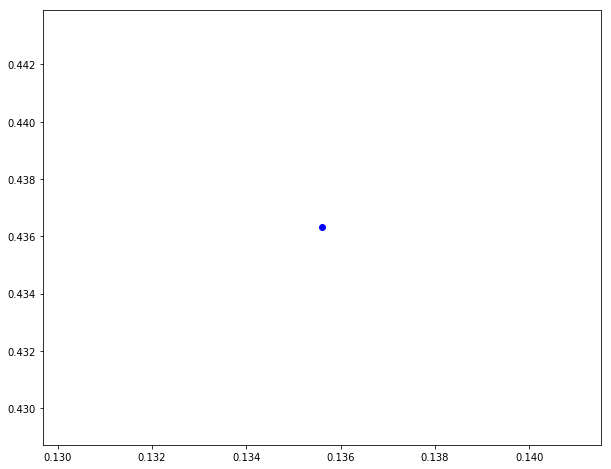

In [103]:
# Let's plot the results
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 8]

for index, speech in enumerate(simple_data.index):
    x = data_clean[data_clean.index == speech].polarity
    y = data_clean[data_clean.index == speech].subjectivity
    plt.scatter(x, y, color='blue')
    plt.text(x+.001, y+.001, simple_data[index], fontsize=10)
    plt.xlim(-.01, .12) 
    
plt.title('Sentiment Analysis', fontsize=20)
plt.xlabel('<-- Negative -------- Positive -->', fontsize=15)
plt.ylabel('<-- Facts -------- Opinions -->', fontsize=15)

plt.show()

In [107]:
# Let's take a look at our data again
data_clean[data_clean.index == 2113]

,public_url,headline,description,event,duration,published,tags,views,text,speaker_1,...,speaker3_profile,speaker_4,speaker4_occupation,speaker4_introduction,speaker4_profile,speech_length,reached_threshold,prefers,polarity,subjectivity
Talk_ID,,,,,,,,,,,,,,,,,,,,,
2113,https://www.ted.com/talks/fred_swaniker_the_le...,"The leaders who ruined Africa, and the generat...","Before he hit eighteen, Fred Swaniker had live...",TEDGlobal 2014,0:13:26,10/21/14,"TED Fellows,Africa,entrepreneur",1277831,ruin generation fix ted entrepreneur hit eight...,Fred Swaniker,...,NaN,NaN,NaN,NaN,NaN,11591,1,0,0.192542,0.473747


In [108]:
# Let's create a list to hold all of the pieces of text
list_pieces = []
for t in data_clean.text:
    # call function to split each speech into 10 segments
    split = split_text(t)
    list_pieces.append(split)
    
list_pieces[:5]

[['avert climate crisis alternative energy global issue climate change environment science culture technology humor humanity exude inconvenient truth al gore spell ways address climate change immediately buy hybrid invent new hotter brand name global warm thank much truly great honor opportunity come stage twice extremely grateful blow away conference want thank many nice comment say night say sincerely partly mock sob need put position fly air force two eight take shoe boot get airplane tell one quick story illustrate like true story every bite true soon tipper leave mock sob',
  ' white house drive home little farm east drive know sound like little thing look rear view mirror sudden hit motorcade back hear phantom limb pain rent ford dinnertime start look place eat get exit get exit find restaurant low cost family restaurant chain know go sit booth waitress come make big commotion tipper take order go couple booth next us lower voice much really strain hear say say yes former vice pr

In [109]:
# The list has 1591 elements, one for each transcript
len(list_pieces)

1591

In [110]:
# Each transcript has been split into 10 pieces of text
len(list_pieces[0])

10

In [111]:
# Each transcript has been split into 10 pieces of text
len(list_pieces[0])

# Calculate the polarity for each piece of text
polarity_transcript = []
for lp in list_pieces:
    polarity_piece = []
    for p in lp:
        polarity_piece.append(TextBlob(p).sentiment.polarity)
    polarity_transcript.append(polarity_piece)
    
polarity_transcript

[[0.2963131313131313,
  0.1203125,
  0.07205882352941177,
  0.13279220779220777,
  0.1071969696969697,
  0.18665223665223662,
  0.11130952380952382,
  -0.037500000000000006,
  0.13898809523809524,
  0.2153846153846154],
 [0.05982722634508348,
  0.05523925479282621,
  0.02664772727272727,
  0.03269264069264069,
  0.0356060606060606,
  0.05984390609390608,
  0.020402892561983466,
  0.03720238095238095,
  0.054340628507295194,
  0.02943017127799737],
 [0.1854341736694678,
  0.08749999999999998,
  -0.07562111801242236,
  0.1060369318181818,
  0.13475625823451906,
  0.25249433106575964,
  0.15364583333333334,
  0.19646464646464645,
  0.15432539682539684,
  0.20693722943722942],
 [0.0775,
  0.033095238095238094,
  0.050157418339236495,
  -0.02840909090909092,
  0.1984217171717171,
  0.16553030303030306,
  0.13686274509803922,
  -0.0715686274509804,
  0.14613636363636362,
  0.24446969696969695],
 [0.1762142857142857,
  0.20918753865182435,
  0.0332447490780824,
  0.09138311688311689,
  0.0543

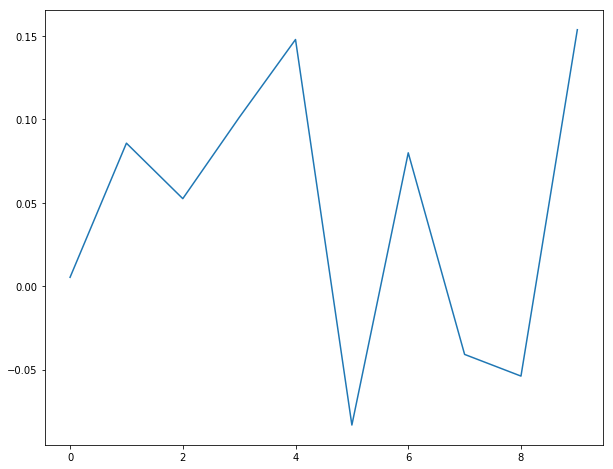

In [112]:
# Show the plot for one speech
plt.plot(polarity_transcript[-1])
#plt.title(data[1])
plt.show()

In [113]:
simple_data.head()

,text
Talk_ID,
1,avert climate crisis alternative energy global...
53,green ghetto grant green activism politics pol...
66,school kill creativity teach creativity parent...
92,best ever see global issue global development ...
96,entertainment goal set potential psychology mo...


/Users/flatironschool/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/flatironschool/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


ValueError: num must be 1 <= num <= 12, not 13

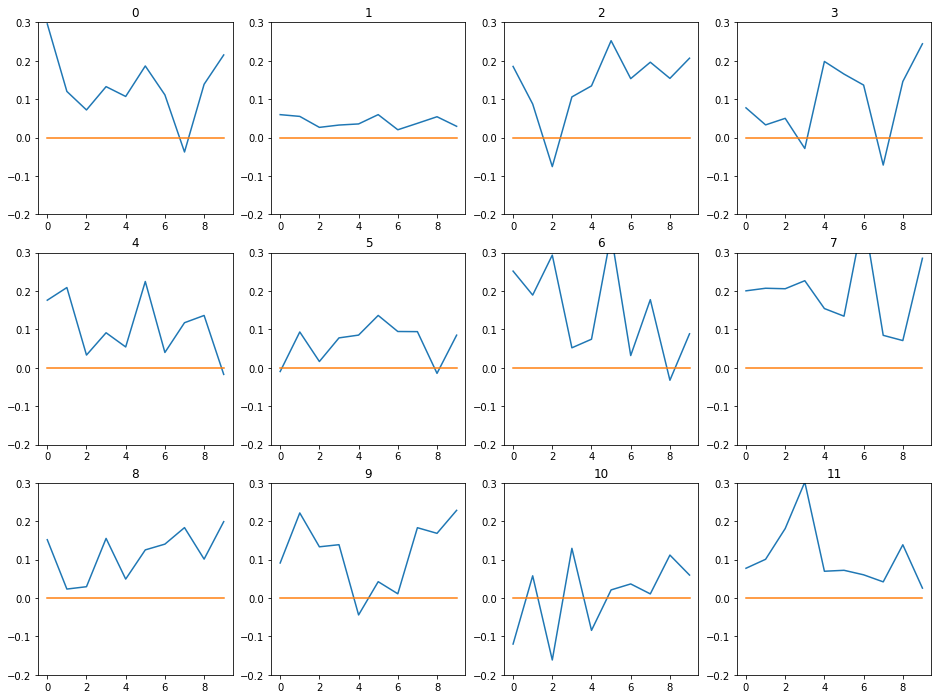

In [114]:
# Show the plot for all comedians
plt.rcParams['figure.figsize'] = [16, 12]

for index, speech in enumerate(simple_data.index):    
    plt.subplot(3, 4, index+1)
    plt.plot(polarity_transcript[index])
    plt.plot(np.arange(0,10), np.zeros(10))
    plt.title(index)
    plt.ylim(ymin=-.2, ymax=.3)
    
plt.show()

In [132]:
data_clean.to_pickle('data_clean.pkl')

### LDA

#### Topic Modeling - Attempt #1

In [ ]:
data = data_dtm

In [ ]:
# One of the required inputs is a term-document matrix
tdm = data.transpose()
tdm.head()

In [ ]:
# We're going to put the term-document matrix into a new gensim format, from df --> sparse matrix --> gensim corpus
sparse_counts = scipy.sparse.csr_matrix(tdm)
corpus = matutils.Sparse2Corpus(sparse_counts)

In [ ]:
type(cv.vocabulary_)

In [ ]:
# Gensim also requires dictionary of the all terms and their respective location in the term-document matrix
cv = pickle.load(open("cv_stop.pkl", "rb"))

# for unwanted_key in add_stop_words:
#     if unwanted_key in cv.vocabulary_:
#         del cv.vocabulary_[unwanted_key] # JAY STYLE
id2word = dict((v, k) for k, v in cv.vocabulary_.items())

In [ ]:
len(id2word)

In [ ]:
# Now that we have the corpus (term-document matrix) and id2word (dictionary of location: term),
# we need to specify two other parameters as well - the number of topics and the number of passes
lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=2, passes=10)
lda.print_topics()

In [ ]:
# LDA for num_topics = 3
lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=3, passes=10)
lda.print_topics()

In [ ]:
# LDA for num_topics = 4
lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=4, passes=10)
lda.print_topics()

#### Topic Modeling - Attempt #2 (Nouns Only)

In [ ]:
# Let's create a function to pull out nouns from a string of text
from nltk import word_tokenize, pos_tag

def nouns(text):
    '''Given a string of text, tokenize the text and pull out only the nouns.'''
    is_noun = lambda pos: pos[:2] == 'NN'
    tokenized = word_tokenize(text)
    all_nouns = [word for (word, pos) in pos_tag(tokenized) if is_noun(pos)] 
    return ' '.join(all_nouns)

In [194]:
# Read in the cleaned data, before the CountVectorizer step
data_clean = pd.read_pickle('data_clean.pkl')
data_clean

,Talk_ID,public_url,headline,description,event,duration,published,tags,views,text,...,speaker_4,speaker4_occupation,speaker4_introduction,speaker4_profile,speech_length,reached_threshold,prefers,tag,polarity,subjectivity
0,1,https://www.ted.com/talks/al_gore_on_averting_...,Averting the climate crisis,With the same humor and humanity he exuded in ...,TED2006,0:16:17,6/27/06,"alternative energy,cars,global issues,climate ...",3266733,avert climate crisis alternative humor humanit...,...,NaN,NaN,NaN,NaN,12074,1,1,alternative energy,0.142703,0.451107
9,53,https://www.ted.com/talks/majora_carter_s_tale...,Greening the ghetto,"In an emotionally charged talk, MacArthur-winn...",TED2006,0:18:36,6/27/06,"MacArthur grant,cities,green,activism,politics...",2000421,green ghetto emotionally charge talk activist ...,...,NaN,NaN,NaN,NaN,18477,1,1,MacArthur grant,0.040806,0.417995
18,66,https://www.ted.com/talks/ken_robinson_says_sc...,Do schools kill creativity?,Sir Ken Robinson makes an entertaining and pro...,TED2006,0:19:24,6/27/06,"children,teaching,creativity,parenting,culture...",51614087,school kill creativity sir ken make entertain ...,...,NaN,NaN,NaN,NaN,17801,1,0,children,0.132291,0.471794
25,92,https://www.ted.com/talks/hans_rosling_shows_t...,The best stats you've ever seen,You've never seen data presented like this. Wi...,TED2006,0:19:50,6/27/06,"demo,Asia,global issues,visualizations,global ...",12662135,best ever see never see data present like dram...,...,NaN,NaN,NaN,NaN,17561,1,1,demo,0.098429,0.462222
36,96,https://www.ted.com/talks/tony_robbins_asks_wh...,Why we do what we do,"Tony Robbins discusses the ""invisible forces"" ...",TED2006,0:21:45,6/27/06,"entertainment,goal-setting,potential,psycholog...",22368699,tony discuss invisible force motivate action a...,...,NaN,NaN,NaN,NaN,23666,1,0,entertainment,0.103277,0.495314
44,49,https://www.ted.com/talks/joshua_prince_ramus_...,Behind the design of Seattle's library,Architect Joshua Prince-Ramus takes the audien...,TED2006,0:19:58,7/10/06,"library,architecture,design,culture,collaboration",1042335,behind design library architect take audience ...,...,NaN,NaN,NaN,NaN,18794,0,0,library,0.066519,0.387698
49,71,https://www.ted.com/talks/rick_warren_on_a_lif...,A life of purpose,"Pastor Rick Warren, author of ""The Purpose-Dri...",TED2006,0:21:02,7/18/06,"Christianity,philanthropy,religion,God,happine...",3361934,life purpose pastor rick warren author life re...,...,NaN,NaN,NaN,NaN,18097,1,1,Christianity,0.135496,0.439532
57,94,https://www.ted.com/talks/dan_dennett_s_respon...,Let's teach religion -- all religion -- in sch...,Philosopher Dan Dennett calls for religion -- ...,TED2006,0:24:45,7/18/06,"atheism,consciousness,evolution,philosophy,rel...",2751013,let us teach religion religion school philosop...,...,NaN,NaN,NaN,NaN,20267,1,0,atheism,0.205399,0.527502
65,54,https://www.ted.com/talks/cameron_sinclair_on_...,My wish: A call for open-source architecture,"Accepting his 2006 TED Prize, Cameron Sinclair...",TED2006,0:23:34,7/25/06,"disaster relief,open-source,philanthropy,globa...",1248115,wish call architecture disaster accept ted pri...,...,NaN,NaN,NaN,NaN,20434,0,1,disaster relief,0.130867,0.433216
75,55,https://www.ted.com/talks/jehane_noujaim_inspi...,My wish: A global day of film,Jehane Noujaim unveils her 2006 TED Prize wish...,TED2006,0:25:38,7/25/06,"TED Prize,peace,entertainment,movies,global is...",409921,wish global day film ted change unveil ted pri...,...,NaN,NaN,NaN,NaN,21513,0,1,TED Prize,0.119225,0.478806


In [ ]:
# Apply the nouns function to the transcripts to filter only on nouns
data_nouns = pd.DataFrame(data_clean.text.apply(nouns))
data_nouns

In [ ]:
# Create a new document-term matrix using only nouns
# from sklearn.feature_extraction import text
# from sklearn.feature_extraction.text import CountVectorizer

# Re-add the additional stop words since we are recreating the document-term matrix

stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

# Recreate a document-term matrix with only nouns
cvn = CountVectorizer(stop_words=stop_words)
data_cvn = cvn.fit_transform(data_nouns.text)
data_dtmn = pd.DataFrame(data_cvn.toarray(), columns=cvn.get_feature_names())
data_dtmn.index = data_nouns.index
data_dtmn

In [ ]:
# Create the gensim corpus
corpusn = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtmn.transpose()))

# Create the vocabulary dictionary
id2wordn = dict((v, k) for k, v in cvn.vocabulary_.items())

In [ ]:
# Let's start with 2 topics
ldan = models.LdaModel(corpus=corpusn, num_topics=2, id2word=id2wordn, passes=10)
ldan.print_topics()

In [ ]:
# Let's try topics = 3
ldan = models.LdaModel(corpus=corpusn, num_topics=3, id2word=id2wordn, passes=10)
ldan.print_topics()

In [ ]:
# Let's try 4 topics
ldan = models.LdaModel(corpus=corpusn, num_topics=4, id2word=id2wordn, passes=10)
ldan.print_topics()

#### Topic Modeling - Attempt #3 (Nouns and Adjectives)

In [ ]:
# Let's create a function to pull out nouns from a string of text
def nouns_adj(text):
    '''Given a string of text, tokenize the text and pull out only the nouns and adjectives.'''
    is_noun_adj = lambda pos: pos[:2] == 'NN' or pos[:2] == 'JJ'
    tokenized = word_tokenize(text)
    nouns_adj = [word for (word, pos) in pos_tag(tokenized) if is_noun_adj(pos)] 
    return ' '.join(nouns_adj)

In [ ]:
# Apply the nouns function to the transcripts to filter only on nouns
data_nouns_adj = pd.DataFrame(data_clean.text.apply(nouns_adj))
data_nouns_adj

In [ ]:
# Re-add the additional stop words since we are recreating the document-term matrix
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

# Create a new document-term matrix using only nouns and adjectives, also remove common words with max_df
cvna = CountVectorizer(stop_words=stop_words, max_df=.75)
data_cvna = cvna.fit_transform(data_nouns_adj.text)
data_dtmna = pd.DataFrame(data_cvna.toarray(), columns=cvna.get_feature_names())
data_dtmna.index = data_nouns_adj.index
data_dtmna

In [ ]:
# Create the gensim corpus
corpusna = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtmna.transpose()))

# Create the vocabulary dictionary
id2wordna = dict((v, k) for k, v in cvna.vocabulary_.items())

In [ ]:
# Let's start with 2 topics
ldana = models.LdaModel(corpus=corpusna, num_topics=7, id2word=id2wordna, passes=10)
ldana.print_topics()

In [ ]:
import pyLDAvis.gensim
viz_data = pyLDAvis.prepare(ldana)
#pyLDAvis.gensim.prepare(ldana, corpusna, id2wordna)

In [ ]:
# Let's try 3 topics
ldana = models.LdaModel(corpus=corpusna, num_topics=3, id2word=id2wordna, passes=10)
ldana.print_topics()

In [ ]:
# Let's try _ topics
ldana = models.LdaModel(corpus=corpusna, num_topics=4, id2word=id2wordna, passes=10)
ldana.print_topics()

In [ ]:
# Let's try _ topics
ldana = models.LdaModel(corpus=corpusna, num_topics=8, id2word=id2wordna, passes=10)
ldana.print_topics()

In [ ]:
# LDA visuals
ldamodel = ldana
# Reset the output dimensions
plt.rcParams['figure.figsize'] = [30, 30]

for t in range(ldamodel.num_topics):
    plt.figure()
    plt.imshow(WordCloud().fit_words(dict(ldamodel.show_topic(t, 200))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()

#### Identify Topics in Each Document

In [ ]:
# Our final LDA model (for now)
ldana = models.LdaModel(corpus=corpusna, num_topics=4, id2word=id2wordna, passes=80)
ldana.print_topics()

In [ ]:
# Let's take a look at which topics each transcript contains
corpus_transformed = ldana[corpusna]
list(zip([a for [(a,b)] in corpus_transformed], data_dtmna.index))

In [ ]:
data.columns

In [ ]:
wc = WordCloud(stopwords=stop_words, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

In [ ]:
data_clean.head(20)

In [ ]:
data_clean.reset_index(inplace=True)

In [ ]:
data_clean.columns

In [ ]:
# Reset the output dimensions
plt.rcParams['figure.figsize'] = [21, 300]

# Create subplots for 300 speeches
for speech_num in list(range(0,300)):
    wc.generate(data_clean.text[speech_num])
    
    plt.subplot(100, 3, speech_num+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(speech_num)
    
plt.show()

In [ ]:
data_clean.text[113]

In [ ]:
pd.set_option('max_colwidth',800)
data_clean.iloc[111:114]

In [ ]:
pd.reset_option('max_colwidth')
df.iloc[112:115]

In [ ]:
df.text.iloc[113]

In [ ]:
df.iloc[50:60]

In [ ]:
# Read in cleaned data
dtm_stop = pd.read_pickle('dtm_stop.pkl')
dtm_stop.head()

#### Trying simple Text Classifier

In [ ]:
# Let's update our document-term matrix with the new list of stop words
from sklearn.feature_extraction import text 
#from sklearn.feature_extraction.text import CountVectorizer

# Read in cleaned data
data_clean = pd.read_pickle('data_clean.pkl')
data_clean.head()

In [ ]:
simple_data = data_clean[['Talk_ID','text', 'reached_threshold']]
simple_data = simple_data.sample(frac=1).reset_index(drop=True)  # shuffle
print(simple_data.shape)
simple_data.head()

In [ ]:
simple_data.set_index('Talk_ID', inplace=True)
print(simple_data.shape)
simple_data.head()

In [ ]:
simple_data.text

In [ ]:
# Add new stop words
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# cv = CountVectorizer(stop_words=stop_words)
# data_cv = cv.fit_transform(data_clean.text)

# data_stop = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
# data_stop.index = data_clean.index

# Pickle it for later use
# pickle.dump(cv, open("cv_stop.pkl", "wb"))
# data_stop.to_pickle("dtm_stop.pkl")

In [ ]:
vocabulary = list(dtm_stop.columns)

In [ ]:
count_vectorizer = CountVectorizer(stop_words=stop_words, vocabulary=vocabulary)

In [ ]:
counts = cv.fit_transform(simple_data['text'].values)

In [ ]:
from sklearn.naive_bayes import MultinomialNB

classifier = MultinomialNB()
targets = simple_data['reached_threshold'].values
classifier.fit(counts, targets)

In [ ]:
examples = ['part of the journey', 'keep mindful of present moment']
example_counts = count_vectorizer.transform(examples)
predictions = classifier.predict(example_counts)
predictions

#### Let's Try Again

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
sentences = simple_data['text'].values
y = simple_data['reached_threshold'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.25, random_state=1000)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)
X_train

In [ ]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)

print("Accuracy:", score)

In [ ]:
# pd.set_option('max_colwidth',2000)
# pd.reset_option('max_colwidth')
data_clean.reset_index(inplace=True, drop=True)
data_clean.head()

In [ ]:
data_clean.columns

In [ ]:
data_clean.drop(['index'], axis=1, inplace=True)
data_clean.head()

In [ ]:
pd.set_option('max_colwidth',1000)
data_clean.text.head(1)

In [ ]:
# Let's pickle it for later use
data_clean.to_pickle("latecomer_fj.pkl")

#### Cosine Similarity

In [ ]:
def cosine_distance_countvectorizer_method(s1, s2):
    
    # sentences to list
    allsentences = [s1 , s2]
    
    # packages
    # from sklearn.feature_extraction.text import CountVectorizer
    from scipy.spatial import distance
    
    # text to vector
    vectorizer = CountVectorizer()
    all_sentences_to_vector = vectorizer.fit_transform(allsentences)
    text_to_vector_v1 = all_sentences_to_vector.toarray()[0].tolist()
    text_to_vector_v2 = all_sentences_to_vector.toarray()[1].tolist()
    
    # distance of similarity
    cosine = distance.cosine(text_to_vector_v1, text_to_vector_v2)
    print('Similarity of two sentences are equal to ',round((1-cosine)*100,2),'%')
    return cosine

In [ ]:
ss1 = 'The president greets the press in Chicago'
ss2 = 'Obama speaks to the media in Illinois'

In [ ]:
cosine_distance_countvectorizer_method(ss1 , ss2)

O-Reilly Example https://www.oreilly.com/learning/how-do-i-compare-document-similarity-using-python

### Gensim Similarity Model

In [14]:
# Read in cleaned data
data_clean = pd.read_pickle('data_clean.pkl')
data_clean.columns

Index(['public_url', 'headline', 'description', 'event', 'duration',
       'published', 'tags', 'views', 'text', 'speaker_1',
       'speaker1_occupation', 'speaker1_introduction', 'speaker1_profile',
       'speaker_2', 'speaker2_occupation', 'speaker2_introduction',
       'speaker2_profile', 'speaker_3', 'speaker3_occupation',
       'speaker3_introduction', 'speaker3_profile', 'speaker_4',
       'speaker4_occupation', 'speaker4_introduction', 'speaker4_profile',
       'speech_length', 'reached_threshold', 'prefers'],
      dtype='object')

In [33]:
pd.set_option('max_colwidth',1000)
# pd.reset_option('max_colwidth')
data_clean[data_clean.index == 41].text

1

In [5]:
data_clean.reset_index(inplace=True, drop=True)
data_clean.head()

,public_url,headline,description,event,duration,published,tags,views,text,speaker_1,...,speaker3_occupation,speaker3_introduction,speaker3_profile,speaker_4,speaker4_occupation,speaker4_introduction,speaker4_profile,speech_length,reached_threshold,prefers
0,https://www.ted.com/talks/al_gore_on_averting_climate_crisis,Averting the climate crisis,"With the same humor and humanity he exuded in ""An Inconvenient Truth,"" Al Gore spells out 15 ways that individuals can address climate change immediately, from buying a hybrid to inventing a new, hotter brand name for global warming.",TED2006,0:16:17,6/27/06,"alternative energy,cars,global issues,climate change,environment,science,culture,sustainability,technology",3266733,avert climate crisis alternative energy global issue climate change environment science culture technology humor humanity exude inconvenient truth al gore spell ways address climate change immediately buy hybrid invent new hotter brand name global warm thank much truly great honor opportunity come stage twice extremely grateful blow away conference want thank many nice comment say night say sincerely partly mock sob need laughter put position laughter fly air force two eight laughter take shoe boot get airplane laughter applause tell one quick story illustrate like laughter true story every bite true soon tipper leave mock sob white house laughter drive home little farm east drive laughter know sound like little thing laughter look rear view mirror sudden hit motorcade back laughter hear phantom limb pain laughter rent ford laughter dinnertime start look place eat get exit get exit find restaurant low cost family restaurant chain know go sit booth waitress come make big commotion t...,Al Gore,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12074,1,1
1,https://www.ted.com/talks/majora_carter_s_tale_of_urban_renewal,Greening the ghetto,"In an emotionally charged talk, MacArthur-winning activist Majora Carter details her fight for environmental justice in the South Bronx -- and shows how minority neighborhoods suffer most from flawed urban policy.",TED2006,0:18:36,6/27/06,"MacArthur grant,cities,green,activism,politics,pollution,environment,inequality,business",2000421,green ghetto grant green activism politics pollution environment inequality business emotionally charge talk win activist carter detail fight environmental justice south show minority suffer flaw urban policy today happy hear sustainable development save us however ted often tell real policy agenda feasible especially large urban like new york city people decision make power public private sector really feel though danger reason today part dog abandon puppy find back rain back turn much bigger dog would anticipate come life fight huge waste facility plan east river waterfront despite fact small part new york city already handle percent entire city commercial waste sewage treatment plant sewage sludge plant four power plant world food distribution center well bring diesel truck trip area week area also one park people city contact park department seed grant initiative help develop waterfront project think really well mean bite naive would live area life could get river lovely mentio...,Majora Carter,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18477,1,1
2,https://www.ted.com/talks/ken_robinson_says_schools_kill_creativity,Do schools kill creativity?,Sir Ken Robinson makes an entertaining and profoundly moving case for creating an education system that nurtures (rather than undermines) creativity.,TED2006,0:19:24,6/27/06,"children,teaching,creativity,parenting,culture,dance,education",51614087,school kill creativity teach creativity parent culture dance education sir ken make entertain profoundly move case create education system nurture rather undermine creativity good morning laughter great blow away whole thing fact leave laughter three theme run conference relevant want talk one extraordinary evidence human creativity people variety range second put us place idea go happen term f

In [15]:
data_clean.describe()

,views,speech_length,reached_threshold,prefers
count,1.591000e+03,1591.000000,1591.000000,1591.000000
mean,1.940542e+06,11652.783784,0.488372,0.522313
std,2.936802e+06,5271.789839,0.500022,0.499659
min,1.914690e+05,1576.000000,0.000000,0.000000
25%,8.792555e+05,7567.000000,0.000000,0.000000
50%,1.239901e+06,11834.000000,0.000000,1.000000
75%,1.910758e+06,15344.500000,1.000000,1.000000
max,5.161409e+07,35091.000000,1.000000,1.000000


In [7]:
length = len(data_clean)
length

1591

In [8]:
simple_data = data_clean[['public_url', 'headline', 'description', 'event', 'duration', 'published',
                         'speaker_1','speaker1_occupation', 'speaker1_introduction', 'speaker1_profile',
                         'speech_length', 'reached_threshold', 'prefers', 'polarity','subjectivity',
                          'text']]
# simple_data = simple_data.sample(frac=1).reset_index(drop=True)  # shuffle
simple_data.iloc[0]

KeyError: "['subjectivity', 'polarity'] not in index"

In [120]:
def nltk_tokenize(text):
    return [w.lower() for w in word_tokenize(text)]

def search_function(text_list, choice, search_words):
    length = len(text_list)
    text_list = [text_list.iloc[i] for i in range(length)]

    gen_docs = []
    for i in range(length):
        gen_docs.append(nltk_tokenize(text_list[i]))
    dictionary = gensim.corpora.Dictionary(gen_docs)

    corpus = []
    for i in range(length):
        corpus.append(dictionary.doc2bow(gen_docs[i]))
    tf_idf = gensim.models.TfidfModel(corpus)
#    print(tf_idf) # remove later
    sims = gensim.similarities.Similarity('Archives/',tf_idf[corpus],
                                      num_features=len(dictionary))
#    print(sims) # remove later
    # TRY OUT QUERIES
    query_doc = [w.lower() for w in word_tokenize(search_words)]
#    print(query_doc)  # remove later
    query_doc_bow = dictionary.doc2bow(query_doc)
#    print(query_doc_bow) # remove later
    query_doc_tf_idf = tf_idf[query_doc_bow]
#    print(query_doc_tf_idf) # remove later
    ans = sims[query_doc_tf_idf]
    ind = np.argmax(ans)
    print('INDEX = ', ind)
    return ind

In [121]:
def preprocess(data):
    
    lemmatized = [lemmadata(speech) for speech in data]
    
    tfidf = pickle.load(open("tfidf.pkl", "rb"))
    
    transformed = tfidf.transform(lemmatized)
    tfidf_df = pd.DataFrame(transformed.toarray(), columns=tfidf.get_feature_names())
    
    relevant = pickle.load(open("relevantwords.pkl", "rb"))
    
    testset = [tfidf_df[word] for word in relevant if word in tfidf_df.columns]
    
    return pd.DataFrame(testset).transpose()

In [127]:
x = simple_data['text']
y = simple_data['prefers']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

lemmatized = [lemmadata(t) for t in x_train]
tfidf = TfidfVectorizer()
response = tfidf.fit_transform(lemmatized)
tfidf_df = pd.DataFrame(response.toarray(), columns=tfidf.get_feature_names())

relevant = []
for word in tfidf_df.columns:
    if tfidf_df[word].mean() > 0.0001:
        relevant.append(tfidf_df[word])
relevant_df = pd.DataFrame(relevant).transpose()
pickle.dump(tfidf, open("tfidf.pkl", "wb"))
pickle.dump(relevant_df.columns, open("relevantwords.pkl", "wb"))

mnb = MultinomialNB()
mnb.fit(relevant_df, y_train)

In [129]:
def classify_text(text, mnb):
    listtext = [text]
    processed = preprocess(listtext)
    return mnb.predict(processed)
#    test = preprocess(x_test)
#    mnb_pred = mnb.predict(test)
#     return classify_text(search_words)
#     listtext = [search_words]
#     processed = preprocess(listtext)
#     return mnb.predict(processed)

Enter
1 for TEDTalks Search
2 for TEDTalks Classifier: 1
Enter
1 to Search by Description
2 to Search by Speech Transcript: 1
Enter Search Term(s): poopy heads


adding document #0 to Dictionary(0 unique tokens: [])
built Dictionary(12438 unique tokens: ["''", ',', '.', '15', '``']...) from 1591 documents (total 98251 corpus positions)
collecting document frequencies
PROGRESS: processing document #0
calculating IDF weights for 1591 documents and 12438 features (77977 matrix non-zeros)
starting similarity index under Archives/
creating sparse index
creating sparse matrix from corpus
PROGRESS: at document #0/1591
created <1591x12438 sparse matrix of type '<class 'numpy.float32'>'
	with 77977 stored elements in Compressed Sparse Row format>
creating sparse shard #0
saving index shard to Archives/.0
saving SparseMatrixSimilarity object under Archives/.0, separately None
saved Archives/.0
loading SparseMatrixSimilarity object from Archives/.0
loaded Archives/.0


INDEX =  637
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

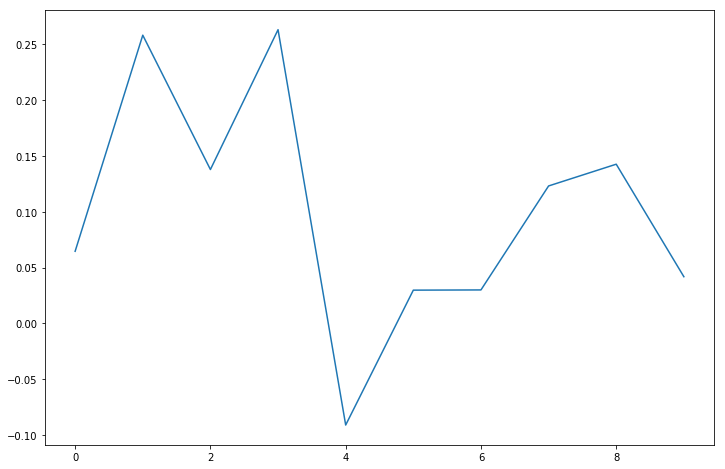

In [137]:
num = '' 
num2 = ''
plt.rcParams['figure.figsize'] = [12, 8]

while num != '1' and num != '2':
    num = input('Enter\n1 for TEDTalks Search\n2 for TEDTalks Classifier: ')
    if num == '1':
        while num2 != '1' and num2 != '2':
            num2 = input('Enter\n1 to Search by Description\n2 to Search by Speech Transcript: ')
            if num2 == '1':
                choice = 'description'
            elif num2 == '2':
                choice = 'text'
            search_words = input('Enter Search Term(s): ')
            # search_words = sample_text1590 # test queries
            idx = search_function(simple_data[choice], choice, search_words)
            print(pd.DataFrame(simple_data.iloc[idx].T))
            driver = webdriver.Chrome()
            driver.get(simple_data['public_url'].iloc[idx])
#            print(simple_data['public_url'].iloc[idx])
            play = driver.find_element_by_xpath('//*[@id="plyr-play"]')
            time.sleep(3)
            play.click()
            # Show the plot for one speech
            plt.plot(polarity_transcript[idx])
            #plt.title(simple_data.headline[ind])
            plt.show()
    elif num == '2':
        search_words = input('Enter Search Term(s): ')
        result = classify_text(search_words, mnb)
        if result == [1]:
            print("One of Jay's favorite topics!")
        else:
            print("Not one of Jay's favorite topics")

In [56]:
driver.quit()

In [142]:
df = simple_data.text

In [158]:
print(len(gen_docs), gen_docs[0])

1591 ['avert', 'climate', 'crisis', 'alternative', 'humor', 'humanity', 'exude', 'inconvenient', 'truth', 'al', 'gore', 'spell', 'ways', 'address', 'climate', 'change', 'immediately', 'buy', 'hybrid', 'invent', 'new', 'hotter', 'brand', 'name', 'global', 'warm', 'thank', 'much', 'truly', 'great', 'honor', 'opportunity', 'come', 'stage', 'twice', 'extremely', 'grateful', 'blow', 'away', 'conference', 'want', 'thank', 'many', 'nice', 'comment', 'say', 'night', 'say', 'sincerely', 'partly', 'mock', 'sob', 'need', 'laughter', 'put', 'position', 'laughter', 'fly', 'air', 'force', 'two', 'eight', 'laughter', 'take', 'shoe', 'boot', 'get', 'airplane', 'laughter', 'applause', 'tell', 'one', 'quick', 'story', 'illustrate', 'like', 'laughter', 'true', 'story', 'every', 'bite', 'true', 'soon', 'tipper', 'leave', 'mock', 'sob', 'white', 'house', 'laughter', 'drive', 'home', 'little', 'farm', 'east', 'drive', 'laughter', 'know', 'sound', 'like', 'little', 'thing', 'laughter', 'look', 'mirror', 'sud

In [160]:
len(dictionary)

20501

In [ ]:
# def dtb(text):
#     return dictionary.doc2bow(text)
# corpus = list(list(df.text.apply(dtb)))

In [162]:
corpus[:2]

[[(0, 1),
  (1, 1),
  (2, 3),
  (3, 2),
  (4, 1),
  (5, 2),
  (6, 1),
  (7, 1),
  (8, 2),
  (9, 1),
  (10, 1),
  (11, 5),
  (12, 3),
  (13, 2),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 6),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 5),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 4),
  (38, 2),
  (39, 2),
  (40, 2),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 2),
  (46, 1),
  (47, 2),
  (48, 3),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 2),
  (53, 5),
  (54, 1),
  (55, 1),
  (56, 2),
  (57, 2),
  (58, 1),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 7),
  (63, 1),
  (64, 1),
  (65, 2),
  (66, 3),
  (67, 1),
  (68, 1),
  (69, 7),
  (70, 3),
  (71, 1),
  (72, 1),
  (73, 1),
  (74, 2),
  (75, 9),
  (76, 1),
  (77, 1),
  (78, 1),
  (79, 1),
  (80, 1),
  (81, 1),
  (82, 1),
  (83, 1),
  (84, 1),
  (85, 2),
  (86, 1),
  (87, 3),
  (88, 1),
  (89, 1),
  (90, 2),
  (91, 1)

In [134]:
# TRY OUT QUERIES
query_doc = [w.lower() for w in word_tokenize(sample_text0)]
print(query_doc)  # remove later
query_doc_bow = dictionary.doc2bow(query_doc)
print(query_doc_bow) # remove later
query_doc_tf_idf = tf_idf[query_doc_bow]
print(query_doc_tf_idf) # remove later

['avert', 'climate', 'crisis', 'alternative', 'energy', 'global', 'issue', 'climate', 'change', 'environment', 'science', 'culture', 'technology', 'humor', 'humanity', 'exude', 'inconvenient', 'truth', 'al', 'gore', 'spell', 'ways', 'address', 'climate', 'change', 'immediately', 'buy', 'hybrid', 'invent', 'new', 'hotter', 'brand', 'name', 'global', 'warm', 'thank', 'much', 'truly', 'great', 'honor', 'opportunity', 'come', 'stage', 'twice', 'extremely', 'grateful', 'blow', 'away', 'conference', 'want', 'thank', 'many', 'nice', 'comment', 'say', 'night', 'say', 'sincerely', 'partly', 'mock', 'sob', 'need', 'put', 'position', 'fly', 'air', 'force', 'two', 'eight', 'take', 'shoe', 'boot', 'get', 'airplane', 'tell', 'one', 'quick', 'story', 'illustrate', 'like', 'true', 'story', 'every', 'bite', 'true', 'soon', 'tipper', 'leave', 'mock', 'sob', 'white', 'house', 'drive', 'home', 'little', 'farm', 'east', 'drive', 'know', 'sound', 'like', 'little', 'thing', 'look', 'rear', 'view', 'mirror', 

NameError: name 'dictionary' is not defined

In [166]:
ans = sims[query_doc_tf_idf]
ind = np.argmax(ans)
print(ind)

1591
0


,0
public_url,https://www.ted.com/talks/al_gore_on_averting_...
headline,Averting the climate crisis
description,With the same humor and humanity he exuded in ...
event,TED2006
duration,0:16:17
published,6/27/06
speaker_1,Al Gore
speaker1_occupation,Climate advocate
speaker1_introduction,Nobel Laureate Al Gore focused the world’s att...
speaker1_profile,Why you should listen\nFormer Vice President A...


In [11]:
# pd.set_option('max_colwidth',1200)
pd.reset_option('max_colwidth')
data_clean[data_clean.index == 41]  # index 8737

,public_url,headline,description,event,duration,published,tags,views,text,speaker_1,...,speaker3_occupation,speaker3_introduction,speaker3_profile,speaker_4,speaker4_occupation,speaker4_introduction,speaker4_profile,speech_length,reached_threshold,prefers
41,https://www.ted.com/talks/chris_bangle_says_gr...,Great cars are great art,American designer Chris Bangle explains his ph...,TED2002,0:20:04,4/5/07,"industrial design,transportation,cars,art,desi...",890859,great great art industrial design transportati...,Chris Bangle,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20038,0,0


# Test Cases

In [133]:
sample_text0 = simple_data.text.iloc[0]
print(sample_text0)

avert climate crisis alternative energy global issue climate change environment science culture technology humor humanity exude inconvenient truth al gore spell ways address climate change immediately buy hybrid invent new hotter brand name global warm thank much truly great honor opportunity come stage twice extremely grateful blow away conference want thank many nice comment say night say sincerely partly mock sob need put position fly air force two eight take shoe boot get airplane tell one quick story illustrate like true story every bite true soon tipper leave mock sob white house drive home little farm east drive know sound like little thing look rear view mirror sudden hit motorcade back hear phantom limb pain rent ford dinnertime start look place eat get exit get exit find restaurant low cost family restaurant chain know go sit booth waitress come make big commotion tipper take order go couple booth next us lower voice much really strain hear say say yes former vice president a

In [153]:
sample_text1 = simple_data.text.iloc[1]
print(sample_text1)

green ghetto emotionally charge talk activist carter detail fight environmental justice south show minority suffer flaw urban policy today happy hear sustainable development save us however ted often tell real policy agenda feasible especially large urban like new york city people power public private sector really feel though danger reason today part dog abandon puppy find back rain back turn much bigger dog would anticipate come life fight huge waste facility plan east river waterfront despite fact small part new york city already handle percent entire commercial waste sewage treatment plant sewage sludge plant four power plant center well bring diesel truck trip area week area also one park people city contact park department initiative help develop waterfront project think really bite naive would live area life could get river lovely mention jog dog one morning pull think another illegal dump weed pile garbage stuff mention keep drag lo behold end lot river know forget little aband

In [135]:
sample_text1590 = simple_data.text.iloc[1590]
print(sample_text1590)

role faith belief modern religion faith society community education health care collaboration social change advice believe god religious advise use god responsibility happen live non religious ask keep open mind work faith base especially issue like health care education much potential realize walk across divide faith hand hand try solve many say bear two amaze religious fact father regular response question go church go pray go play tennis case wonder faith find university come house invite us school draw sense personal conviction life service opt baptism faith birthday present faith shape work social entrepreneur attempt address press challenge last work train youth promote ethics across twenty nine later school teacher faith challenge young nine year old ask series question ask god hate quickly retort course god love equally ask many young die stumble mumble respond many reason young die man make cannot blame god ask let happen could stop say yes could yes could send us change light

In [14]:
sample_descr0 = data_clean.description[0]
sample_descr0

'With the same humor and humanity he exuded in "An Inconvenient Truth," Al Gore spells out 15 ways that individuals can address climate change immediately, from buying a hybrid to inventing a new, hotter brand name for global warming.'